In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib
%matplotlib inline
from ovejero import model_trainer, data_tools, bnn_inference
import corner
import os

def NOTIMPLEMENTED():
    raise NotImplementedError('Must specify config/save path')

2023-09-16 23:09:54.394740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 23:09:55.002238: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/parlange/anaconda3/envs/bnn/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


# Testing the Performance of a Model That Has Been Fit

__Author:__ Sebastian Wagner-Carena

__Last Run:__ 08/04/2020

__Goals:__ Learn how to test the performance of a trained model on the validation set.

__Before running this notebook:__ Run the Train_Toy_Model notebook to understand how to train a model. Then train a model with whatever configuration you want. You will have to add the path to the config file in this notebook.

To start, all we have to do is load up our model weights and run it on the validation set. Thankfully, that's pretty easy to do with the BNN inference class. If you don't have a GPU, generating samples for the full validation set can be time consuming (30-40 minutes for 1000 samples). However, by specifying a save path for the samples we only need to do this once.

In [2]:
# First specify the config path
config_path = '/home/parlange/ovejero/test/test_data/diag.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
bnn_infer = bnn_inference.InferenceClass(cfg)

# Now we just have to ask the InferenceClass to spin up some samples from our BNN. The more samples, the more
# accurate our plots and metrics will be. The right value to use unfortunately requires a bit of trial and error.
# 1000 is a good starting point though.
num_samples = 1000
sample_save_dir = '/home/parlange/ovejero/test/test_data/test_samples/'
bnn_infer.gen_samples(num_samples,sample_save_dir=sample_save_dir)

2023-09-16 23:12:38.686726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 23:12:38.725726: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Is model built: True
Loaded weights /home/parlange/ovejero/test/test_data/test_model.h5
TFRecord found at /home/parlange/ovejero/test/test_data/tf_record_test_val
No samples found. Saving samples to /home/parlange/ovejero/test/test_data/test_samples/


  0%|                                                                       | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 198ms/step


  0%|                                                               | 1/1000 [00:00<04:01,  4.14it/s]

1/1 [==============================] - 0s 100ms/step


  0%|▏                                                              | 2/1000 [00:00<02:53,  5.74it/s]

1/1 [==============================] - 0s 85ms/step


  0%|▏                                                              | 3/1000 [00:00<02:24,  6.91it/s]

1/1 [==============================] - 0s 83ms/step


  0%|▎                                                              | 4/1000 [00:00<02:10,  7.65it/s]

1/1 [==============================] - 0s 83ms/step


  0%|▎                                                              | 5/1000 [00:00<02:01,  8.16it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▍                                                              | 6/1000 [00:00<01:56,  8.51it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▍                                                              | 7/1000 [00:00<01:54,  8.69it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▌                                                              | 8/1000 [00:01<01:55,  8.60it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▌                                                              | 9/1000 [00:01<01:53,  8.77it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▌                                                             | 10/1000 [00:01<01:52,  8.82it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▋                                                             | 11/1000 [00:01<01:53,  8.71it/s]

1/1 [==============================] - 0s 87ms/step


  1%|▋                                                             | 12/1000 [00:01<01:55,  8.58it/s]

1/1 [==============================] - 0s 85ms/step


  1%|▊                                                             | 13/1000 [00:01<01:55,  8.51it/s]

1/1 [==============================] - 0s 84ms/step


  1%|▊                                                             | 14/1000 [00:01<01:54,  8.62it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▉                                                             | 15/1000 [00:01<01:55,  8.50it/s]

1/1 [==============================] - 0s 90ms/step


  2%|▉                                                             | 16/1000 [00:01<01:55,  8.53it/s]

1/1 [==============================] - 0s 83ms/step


  2%|█                                                             | 17/1000 [00:02<01:52,  8.75it/s]

1/1 [==============================] - 0s 94ms/step


  2%|█                                                             | 18/1000 [00:02<01:55,  8.47it/s]

1/1 [==============================] - 0s 84ms/step


  2%|█▏                                                            | 19/1000 [00:02<01:53,  8.62it/s]

1/1 [==============================] - 0s 82ms/step


  2%|█▏                                                            | 20/1000 [00:02<01:51,  8.79it/s]

1/1 [==============================] - 0s 100ms/step


  2%|█▎                                                            | 21/1000 [00:02<01:54,  8.55it/s]

1/1 [==============================] - 0s 94ms/step


  2%|█▎                                                            | 22/1000 [00:02<01:59,  8.20it/s]

1/1 [==============================] - 0s 84ms/step


  2%|█▍                                                            | 23/1000 [00:02<01:58,  8.27it/s]

1/1 [==============================] - 0s 85ms/step


  2%|█▍                                                            | 24/1000 [00:02<01:55,  8.43it/s]

1/1 [==============================] - 0s 88ms/step


  2%|█▌                                                            | 25/1000 [00:03<01:53,  8.55it/s]

1/1 [==============================] - 0s 105ms/step


  3%|█▌                                                            | 26/1000 [00:03<01:57,  8.30it/s]

1/1 [==============================] - 0s 99ms/step


  3%|█▋                                                            | 27/1000 [00:03<01:58,  8.19it/s]

1/1 [==============================] - 0s 99ms/step


  3%|█▋                                                            | 28/1000 [00:03<02:00,  8.09it/s]

1/1 [==============================] - 0s 104ms/step


  3%|█▊                                                            | 29/1000 [00:03<02:01,  7.96it/s]

1/1 [==============================] - 0s 102ms/step


  3%|█▊                                                            | 30/1000 [00:03<02:03,  7.86it/s]

1/1 [==============================] - 0s 86ms/step


  3%|█▉                                                            | 31/1000 [00:03<02:00,  8.03it/s]

1/1 [==============================] - 0s 92ms/step


  3%|█▉                                                            | 32/1000 [00:03<01:57,  8.24it/s]

1/1 [==============================] - 0s 98ms/step


  3%|██                                                            | 33/1000 [00:04<01:58,  8.17it/s]

1/1 [==============================] - 0s 102ms/step


  3%|██                                                            | 34/1000 [00:04<01:59,  8.08it/s]

1/1 [==============================] - 0s 92ms/step


  4%|██▏                                                           | 35/1000 [00:04<01:57,  8.21it/s]

1/1 [==============================] - 0s 86ms/step


  4%|██▏                                                           | 36/1000 [00:04<01:54,  8.44it/s]

1/1 [==============================] - 0s 86ms/step


  4%|██▎                                                           | 37/1000 [00:04<01:51,  8.64it/s]

1/1 [==============================] - 0s 92ms/step


  4%|██▎                                                           | 38/1000 [00:04<01:51,  8.65it/s]

1/1 [==============================] - 0s 92ms/step


  4%|██▍                                                           | 39/1000 [00:04<01:51,  8.63it/s]

1/1 [==============================] - 0s 91ms/step


  4%|██▍                                                           | 40/1000 [00:04<01:52,  8.56it/s]

1/1 [==============================] - 0s 88ms/step


  4%|██▌                                                           | 41/1000 [00:04<01:51,  8.61it/s]

1/1 [==============================] - 0s 82ms/step


  4%|██▌                                                           | 42/1000 [00:05<01:48,  8.84it/s]

1/1 [==============================] - 0s 80ms/step


  4%|██▋                                                           | 43/1000 [00:05<01:45,  9.11it/s]

1/1 [==============================] - 0s 80ms/step


  4%|██▋                                                           | 44/1000 [00:05<01:42,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


  4%|██▊                                                           | 45/1000 [00:05<01:42,  9.36it/s]

1/1 [==============================] - 0s 81ms/step


  5%|██▊                                                           | 46/1000 [00:05<01:40,  9.46it/s]

1/1 [==============================] - 0s 79ms/step


  5%|██▉                                                           | 47/1000 [00:05<01:39,  9.58it/s]

1/1 [==============================] - 0s 79ms/step


  5%|██▉                                                           | 48/1000 [00:05<01:38,  9.64it/s]

1/1 [==============================] - 0s 80ms/step


  5%|███                                                           | 49/1000 [00:05<01:39,  9.59it/s]

1/1 [==============================] - 0s 86ms/step


  5%|███                                                           | 50/1000 [00:05<01:40,  9.46it/s]

1/1 [==============================] - 0s 88ms/step


  5%|███▏                                                          | 51/1000 [00:05<01:42,  9.29it/s]

1/1 [==============================] - 0s 87ms/step


  5%|███▏                                                          | 52/1000 [00:06<01:42,  9.25it/s]

1/1 [==============================] - 0s 90ms/step


  5%|███▎                                                          | 53/1000 [00:06<01:45,  8.96it/s]

1/1 [==============================] - 0s 90ms/step


  5%|███▎                                                          | 54/1000 [00:06<01:49,  8.67it/s]

1/1 [==============================] - 0s 86ms/step


  6%|███▍                                                          | 55/1000 [00:06<01:47,  8.83it/s]

1/1 [==============================] - 0s 86ms/step


  6%|███▍                                                          | 56/1000 [00:06<01:46,  8.90it/s]

1/1 [==============================] - 0s 87ms/step


  6%|███▌                                                          | 57/1000 [00:06<01:46,  8.86it/s]

1/1 [==============================] - 0s 88ms/step


  6%|███▌                                                          | 58/1000 [00:06<01:47,  8.77it/s]

1/1 [==============================] - 0s 93ms/step


  6%|███▋                                                          | 59/1000 [00:06<01:49,  8.61it/s]

1/1 [==============================] - 0s 82ms/step


  6%|███▋                                                          | 60/1000 [00:07<01:45,  8.89it/s]

1/1 [==============================] - 0s 86ms/step


  6%|███▊                                                          | 61/1000 [00:07<01:45,  8.91it/s]

1/1 [==============================] - 0s 81ms/step


  6%|███▊                                                          | 62/1000 [00:07<01:42,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


  6%|███▉                                                          | 63/1000 [00:07<01:42,  9.17it/s]

1/1 [==============================] - 0s 84ms/step


  6%|███▉                                                          | 64/1000 [00:07<01:42,  9.13it/s]

1/1 [==============================] - 0s 80ms/step


  6%|████                                                          | 65/1000 [00:07<01:40,  9.33it/s]

1/1 [==============================] - 0s 80ms/step


  7%|████                                                          | 66/1000 [00:07<01:38,  9.47it/s]

1/1 [==============================] - 0s 80ms/step


  7%|████▏                                                         | 67/1000 [00:07<01:39,  9.40it/s]

1/1 [==============================] - 0s 81ms/step


  7%|████▏                                                         | 68/1000 [00:07<01:39,  9.41it/s]

1/1 [==============================] - 0s 81ms/step


  7%|████▎                                                         | 69/1000 [00:07<01:38,  9.44it/s]

1/1 [==============================] - 0s 87ms/step


  7%|████▎                                                         | 70/1000 [00:08<01:39,  9.31it/s]

1/1 [==============================] - 0s 86ms/step


  7%|████▍                                                         | 71/1000 [00:08<01:40,  9.28it/s]

1/1 [==============================] - 0s 86ms/step


  7%|████▍                                                         | 72/1000 [00:08<01:40,  9.25it/s]

1/1 [==============================] - 0s 90ms/step


  7%|████▌                                                         | 73/1000 [00:08<01:41,  9.11it/s]

1/1 [==============================] - 0s 97ms/step


  7%|████▌                                                         | 74/1000 [00:08<01:45,  8.82it/s]

1/1 [==============================] - 0s 93ms/step


  8%|████▋                                                         | 75/1000 [00:08<01:46,  8.65it/s]

1/1 [==============================] - 0s 123ms/step


  8%|████▋                                                         | 76/1000 [00:08<01:58,  7.81it/s]

1/1 [==============================] - 0s 94ms/step


  8%|████▊                                                         | 77/1000 [00:08<01:55,  7.99it/s]

1/1 [==============================] - 0s 99ms/step


  8%|████▊                                                         | 78/1000 [00:09<01:55,  7.98it/s]

1/1 [==============================] - 0s 96ms/step


  8%|████▉                                                         | 79/1000 [00:09<01:54,  8.02it/s]

1/1 [==============================] - 0s 94ms/step


  8%|████▉                                                         | 80/1000 [00:09<01:53,  8.13it/s]

1/1 [==============================] - 0s 107ms/step


  8%|█████                                                         | 81/1000 [00:09<01:56,  7.87it/s]

1/1 [==============================] - 0s 98ms/step


  8%|█████                                                         | 82/1000 [00:09<01:56,  7.90it/s]

1/1 [==============================] - 0s 81ms/step


  8%|█████▏                                                        | 83/1000 [00:09<01:50,  8.32it/s]

1/1 [==============================] - 0s 81ms/step


  8%|█████▏                                                        | 84/1000 [00:09<01:46,  8.61it/s]

1/1 [==============================] - 0s 83ms/step


  8%|█████▎                                                        | 85/1000 [00:09<01:45,  8.64it/s]

1/1 [==============================] - 0s 80ms/step


  9%|█████▎                                                        | 86/1000 [00:10<01:42,  8.91it/s]

1/1 [==============================] - 0s 82ms/step


  9%|█████▍                                                        | 87/1000 [00:10<01:40,  9.06it/s]

1/1 [==============================] - 0s 96ms/step


  9%|█████▍                                                        | 88/1000 [00:10<01:43,  8.80it/s]

1/1 [==============================] - 0s 80ms/step


  9%|█████▌                                                        | 89/1000 [00:10<01:40,  9.02it/s]

1/1 [==============================] - 0s 81ms/step


  9%|█████▌                                                        | 90/1000 [00:10<01:38,  9.19it/s]

1/1 [==============================] - 0s 99ms/step


  9%|█████▋                                                        | 91/1000 [00:10<01:43,  8.80it/s]

1/1 [==============================] - 0s 90ms/step


  9%|█████▋                                                        | 92/1000 [00:10<01:43,  8.76it/s]

1/1 [==============================] - 0s 80ms/step


  9%|█████▊                                                        | 93/1000 [00:10<01:40,  9.00it/s]

1/1 [==============================] - 0s 80ms/step


  9%|█████▊                                                        | 94/1000 [00:10<01:39,  9.14it/s]

1/1 [==============================] - 0s 81ms/step


 10%|█████▉                                                        | 95/1000 [00:10<01:37,  9.28it/s]

1/1 [==============================] - 0s 96ms/step


 10%|█████▉                                                        | 96/1000 [00:11<01:41,  8.92it/s]

1/1 [==============================] - 0s 82ms/step


 10%|██████                                                        | 97/1000 [00:11<01:38,  9.12it/s]

1/1 [==============================] - 0s 87ms/step


 10%|██████                                                        | 98/1000 [00:11<01:38,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 10%|██████▏                                                       | 99/1000 [00:11<01:38,  9.16it/s]

1/1 [==============================] - 0s 88ms/step


 10%|██████                                                       | 100/1000 [00:11<01:38,  9.14it/s]

1/1 [==============================] - 0s 81ms/step


 10%|██████▏                                                      | 101/1000 [00:11<01:37,  9.25it/s]

1/1 [==============================] - 0s 82ms/step


 10%|██████▏                                                      | 102/1000 [00:11<01:36,  9.33it/s]

1/1 [==============================] - 0s 81ms/step


 10%|██████▎                                                      | 103/1000 [00:11<01:35,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 10%|██████▎                                                      | 104/1000 [00:11<01:35,  9.40it/s]

1/1 [==============================] - 0s 83ms/step


 10%|██████▍                                                      | 105/1000 [00:12<01:35,  9.38it/s]

1/1 [==============================] - 0s 82ms/step


 11%|██████▍                                                      | 106/1000 [00:12<01:35,  9.38it/s]

1/1 [==============================] - 0s 86ms/step


 11%|██████▌                                                      | 107/1000 [00:12<01:37,  9.18it/s]

1/1 [==============================] - 0s 80ms/step


 11%|██████▌                                                      | 108/1000 [00:12<01:35,  9.32it/s]

1/1 [==============================] - 0s 81ms/step


 11%|██████▋                                                      | 109/1000 [00:12<01:35,  9.36it/s]

1/1 [==============================] - 0s 88ms/step


 11%|██████▋                                                      | 110/1000 [00:12<01:36,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 11%|██████▊                                                      | 111/1000 [00:12<01:35,  9.33it/s]

1/1 [==============================] - 0s 88ms/step


 11%|██████▊                                                      | 112/1000 [00:12<01:38,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 11%|██████▉                                                      | 113/1000 [00:12<01:36,  9.20it/s]

1/1 [==============================] - 0s 82ms/step


 11%|██████▉                                                      | 114/1000 [00:13<01:35,  9.26it/s]

1/1 [==============================] - 0s 103ms/step


 12%|███████                                                      | 115/1000 [00:13<01:40,  8.83it/s]

1/1 [==============================] - 0s 126ms/step


 12%|███████                                                      | 116/1000 [00:13<01:51,  7.91it/s]

1/1 [==============================] - 0s 97ms/step


 12%|███████▏                                                     | 117/1000 [00:13<01:51,  7.93it/s]

1/1 [==============================] - 0s 90ms/step


 12%|███████▏                                                     | 118/1000 [00:13<01:49,  8.05it/s]

1/1 [==============================] - 0s 83ms/step


 12%|███████▎                                                     | 119/1000 [00:13<01:44,  8.42it/s]

1/1 [==============================] - 0s 80ms/step


 12%|███████▎                                                     | 120/1000 [00:13<01:40,  8.77it/s]

1/1 [==============================] - 0s 81ms/step


 12%|███████▍                                                     | 121/1000 [00:13<01:38,  8.96it/s]

1/1 [==============================] - 0s 83ms/step


 12%|███████▍                                                     | 122/1000 [00:14<01:37,  8.97it/s]

1/1 [==============================] - 0s 80ms/step


 12%|███████▌                                                     | 123/1000 [00:14<01:35,  9.16it/s]

1/1 [==============================] - 0s 84ms/step


 12%|███████▌                                                     | 124/1000 [00:14<01:35,  9.20it/s]

1/1 [==============================] - 0s 93ms/step


 12%|███████▋                                                     | 125/1000 [00:14<01:37,  8.95it/s]

1/1 [==============================] - 0s 82ms/step


 13%|███████▋                                                     | 126/1000 [00:14<01:35,  9.11it/s]

1/1 [==============================] - 0s 81ms/step


 13%|███████▋                                                     | 127/1000 [00:14<01:34,  9.26it/s]

1/1 [==============================] - 0s 80ms/step


 13%|███████▊                                                     | 128/1000 [00:14<01:33,  9.37it/s]

1/1 [==============================] - 0s 80ms/step


 13%|███████▊                                                     | 129/1000 [00:14<01:33,  9.35it/s]

1/1 [==============================] - 0s 84ms/step


 13%|███████▉                                                     | 130/1000 [00:14<01:34,  9.20it/s]

1/1 [==============================] - 0s 79ms/step


 13%|███████▉                                                     | 131/1000 [00:14<01:32,  9.36it/s]

1/1 [==============================] - 0s 79ms/step


 13%|████████                                                     | 132/1000 [00:15<01:31,  9.45it/s]

1/1 [==============================] - 0s 94ms/step


 13%|████████                                                     | 133/1000 [00:15<01:36,  9.00it/s]

1/1 [==============================] - 0s 80ms/step


 13%|████████▏                                                    | 134/1000 [00:15<01:34,  9.19it/s]

1/1 [==============================] - 0s 80ms/step


 14%|████████▏                                                    | 135/1000 [00:15<01:32,  9.37it/s]

1/1 [==============================] - 0s 79ms/step


 14%|████████▎                                                    | 136/1000 [00:15<01:31,  9.45it/s]

1/1 [==============================] - 0s 80ms/step


 14%|████████▎                                                    | 137/1000 [00:15<01:30,  9.56it/s]

1/1 [==============================] - 0s 99ms/step


 14%|████████▍                                                    | 138/1000 [00:15<01:35,  9.02it/s]

1/1 [==============================] - 0s 91ms/step


 14%|████████▍                                                    | 139/1000 [00:15<01:38,  8.72it/s]

1/1 [==============================] - 0s 81ms/step


 14%|████████▌                                                    | 140/1000 [00:15<01:36,  8.89it/s]

1/1 [==============================] - 0s 95ms/step


 14%|████████▌                                                    | 141/1000 [00:16<01:38,  8.74it/s]

1/1 [==============================] - 0s 95ms/step


 14%|████████▋                                                    | 142/1000 [00:16<01:42,  8.38it/s]

1/1 [==============================] - 0s 82ms/step


 14%|████████▋                                                    | 143/1000 [00:16<01:38,  8.67it/s]

1/1 [==============================] - 0s 84ms/step


 14%|████████▊                                                    | 144/1000 [00:16<01:36,  8.85it/s]

1/1 [==============================] - 0s 101ms/step


 14%|████████▊                                                    | 145/1000 [00:16<01:40,  8.51it/s]

1/1 [==============================] - 0s 80ms/step


 15%|████████▉                                                    | 146/1000 [00:16<01:37,  8.75it/s]

1/1 [==============================] - 0s 91ms/step


 15%|████████▉                                                    | 147/1000 [00:16<01:38,  8.66it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█████████                                                    | 148/1000 [00:16<01:37,  8.71it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█████████                                                    | 149/1000 [00:17<01:35,  8.87it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█████████▏                                                   | 150/1000 [00:17<01:33,  9.14it/s]

1/1 [==============================] - 0s 98ms/step


 15%|█████████▏                                                   | 151/1000 [00:17<01:37,  8.73it/s]

1/1 [==============================] - 0s 90ms/step


 15%|█████████▎                                                   | 152/1000 [00:17<01:38,  8.62it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█████████▎                                                   | 153/1000 [00:17<01:36,  8.81it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█████████▍                                                   | 154/1000 [00:17<01:34,  8.91it/s]

1/1 [==============================] - 0s 82ms/step


 16%|█████████▍                                                   | 155/1000 [00:17<01:33,  9.01it/s]

1/1 [==============================] - 0s 81ms/step


 16%|█████████▌                                                   | 156/1000 [00:17<01:32,  9.12it/s]

1/1 [==============================] - 0s 85ms/step


 16%|█████████▌                                                   | 157/1000 [00:17<01:33,  9.00it/s]

1/1 [==============================] - 0s 86ms/step


 16%|█████████▋                                                   | 158/1000 [00:18<01:35,  8.78it/s]

1/1 [==============================] - 0s 84ms/step


 16%|█████████▋                                                   | 159/1000 [00:18<01:34,  8.86it/s]

1/1 [==============================] - 0s 90ms/step


 16%|█████████▊                                                   | 160/1000 [00:18<01:35,  8.78it/s]

1/1 [==============================] - 0s 81ms/step


 16%|█████████▊                                                   | 161/1000 [00:18<01:33,  8.98it/s]

1/1 [==============================] - 0s 86ms/step


 16%|█████████▉                                                   | 162/1000 [00:18<01:33,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 16%|█████████▉                                                   | 163/1000 [00:18<01:33,  8.94it/s]

1/1 [==============================] - 0s 82ms/step


 16%|██████████                                                   | 164/1000 [00:18<01:32,  9.07it/s]

1/1 [==============================] - 0s 102ms/step


 16%|██████████                                                   | 165/1000 [00:18<01:36,  8.61it/s]

1/1 [==============================] - 0s 91ms/step


 17%|██████████▏                                                  | 166/1000 [00:18<01:38,  8.46it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████████▏                                                  | 167/1000 [00:19<01:42,  8.11it/s]

1/1 [==============================] - 0s 83ms/step


 17%|██████████▏                                                  | 168/1000 [00:19<01:40,  8.24it/s]

1/1 [==============================] - 0s 83ms/step


 17%|██████████▎                                                  | 169/1000 [00:19<01:37,  8.53it/s]

1/1 [==============================] - 0s 99ms/step


 17%|██████████▎                                                  | 170/1000 [00:19<01:39,  8.32it/s]

1/1 [==============================] - 0s 82ms/step


 17%|██████████▍                                                  | 171/1000 [00:19<01:37,  8.47it/s]

1/1 [==============================] - 0s 82ms/step


 17%|██████████▍                                                  | 172/1000 [00:19<01:35,  8.68it/s]

1/1 [==============================] - 0s 104ms/step


 17%|██████████▌                                                  | 173/1000 [00:19<01:39,  8.32it/s]

1/1 [==============================] - 0s 82ms/step


 17%|██████████▌                                                  | 174/1000 [00:19<01:37,  8.45it/s]

1/1 [==============================] - 0s 92ms/step


 18%|██████████▋                                                  | 175/1000 [00:20<01:38,  8.35it/s]

1/1 [==============================] - 0s 85ms/step


 18%|██████████▋                                                  | 176/1000 [00:20<01:38,  8.34it/s]

1/1 [==============================] - 0s 82ms/step


 18%|██████████▊                                                  | 177/1000 [00:20<01:36,  8.49it/s]

1/1 [==============================] - 0s 83ms/step


 18%|██████████▊                                                  | 178/1000 [00:20<01:34,  8.67it/s]

1/1 [==============================] - 0s 86ms/step


 18%|██████████▉                                                  | 179/1000 [00:20<01:35,  8.62it/s]

1/1 [==============================] - 0s 83ms/step


 18%|██████████▉                                                  | 180/1000 [00:20<01:35,  8.61it/s]

1/1 [==============================] - 0s 84ms/step


 18%|███████████                                                  | 181/1000 [00:20<01:35,  8.59it/s]

1/1 [==============================] - 0s 83ms/step


 18%|███████████                                                  | 182/1000 [00:20<01:34,  8.66it/s]

1/1 [==============================] - 0s 87ms/step


 18%|███████████▏                                                 | 183/1000 [00:20<01:34,  8.65it/s]

1/1 [==============================] - 0s 82ms/step


 18%|███████████▏                                                 | 184/1000 [00:21<01:32,  8.80it/s]

1/1 [==============================] - 0s 81ms/step


 18%|███████████▎                                                 | 185/1000 [00:21<01:30,  9.00it/s]

1/1 [==============================] - 0s 93ms/step


 19%|███████████▎                                                 | 186/1000 [00:21<01:31,  8.85it/s]

1/1 [==============================] - 0s 90ms/step


 19%|███████████▍                                                 | 187/1000 [00:21<01:33,  8.68it/s]

1/1 [==============================] - 0s 93ms/step


 19%|███████████▍                                                 | 188/1000 [00:21<01:34,  8.63it/s]

1/1 [==============================] - 0s 83ms/step


 19%|███████████▌                                                 | 189/1000 [00:21<01:32,  8.73it/s]

1/1 [==============================] - 0s 84ms/step


 19%|███████████▌                                                 | 190/1000 [00:21<01:31,  8.88it/s]

1/1 [==============================] - 0s 88ms/step


 19%|███████████▋                                                 | 191/1000 [00:21<01:31,  8.84it/s]

1/1 [==============================] - 0s 104ms/step


 19%|███████████▋                                                 | 192/1000 [00:21<01:36,  8.37it/s]

1/1 [==============================] - 0s 86ms/step


 19%|███████████▊                                                 | 193/1000 [00:22<01:35,  8.45it/s]

1/1 [==============================] - 0s 82ms/step


 19%|███████████▊                                                 | 194/1000 [00:22<01:32,  8.73it/s]

1/1 [==============================] - 0s 82ms/step


 20%|███████████▉                                                 | 195/1000 [00:22<01:29,  8.95it/s]

1/1 [==============================] - 0s 81ms/step


 20%|███████████▉                                                 | 196/1000 [00:22<01:29,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


 20%|████████████                                                 | 197/1000 [00:22<01:28,  9.05it/s]

1/1 [==============================] - 0s 82ms/step


 20%|████████████                                                 | 198/1000 [00:22<01:27,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 20%|████████████▏                                                | 199/1000 [00:22<01:26,  9.27it/s]

1/1 [==============================] - 0s 81ms/step


 20%|████████████▏                                                | 200/1000 [00:22<01:25,  9.32it/s]

1/1 [==============================] - 0s 83ms/step


 20%|████████████▎                                                | 201/1000 [00:22<01:25,  9.31it/s]

1/1 [==============================] - 0s 83ms/step


 20%|████████████▎                                                | 202/1000 [00:23<01:27,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 20%|████████████▍                                                | 203/1000 [00:23<01:27,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 20%|████████████▍                                                | 204/1000 [00:23<01:27,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 20%|████████████▌                                                | 205/1000 [00:23<01:26,  9.17it/s]

1/1 [==============================] - 0s 91ms/step


 21%|████████████▌                                                | 206/1000 [00:23<01:28,  8.96it/s]

1/1 [==============================] - 0s 93ms/step


 21%|████████████▋                                                | 207/1000 [00:23<01:30,  8.76it/s]

1/1 [==============================] - 0s 83ms/step


 21%|████████████▋                                                | 208/1000 [00:23<01:29,  8.89it/s]

1/1 [==============================] - 0s 91ms/step


 21%|████████████▋                                                | 209/1000 [00:23<01:29,  8.80it/s]

1/1 [==============================] - 0s 87ms/step


 21%|████████████▊                                                | 210/1000 [00:23<01:32,  8.56it/s]

1/1 [==============================] - 0s 82ms/step


 21%|████████████▊                                                | 211/1000 [00:24<01:30,  8.71it/s]

1/1 [==============================] - 0s 91ms/step


 21%|████████████▉                                                | 212/1000 [00:24<01:32,  8.49it/s]

1/1 [==============================] - 0s 81ms/step


 21%|████████████▉                                                | 213/1000 [00:24<01:31,  8.61it/s]

1/1 [==============================] - 0s 87ms/step


 21%|█████████████                                                | 214/1000 [00:24<01:30,  8.73it/s]

1/1 [==============================] - 0s 85ms/step


 22%|█████████████                                                | 215/1000 [00:24<01:29,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████▏                                               | 216/1000 [00:24<01:28,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 22%|█████████████▏                                               | 217/1000 [00:24<01:27,  8.93it/s]

1/1 [==============================] - 0s 88ms/step


 22%|█████████████▎                                               | 218/1000 [00:24<01:27,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 22%|█████████████▎                                               | 219/1000 [00:24<01:27,  8.91it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████▍                                               | 220/1000 [00:25<01:26,  8.99it/s]

1/1 [==============================] - 0s 81ms/step


 22%|█████████████▍                                               | 221/1000 [00:25<01:25,  9.10it/s]

1/1 [==============================] - 0s 82ms/step


 22%|█████████████▌                                               | 222/1000 [00:25<01:25,  9.15it/s]

1/1 [==============================] - 0s 82ms/step


 22%|█████████████▌                                               | 223/1000 [00:25<01:24,  9.19it/s]

1/1 [==============================] - 0s 98ms/step


 22%|█████████████▋                                               | 224/1000 [00:25<01:29,  8.71it/s]

1/1 [==============================] - 0s 89ms/step


 22%|█████████████▋                                               | 225/1000 [00:25<01:29,  8.70it/s]

1/1 [==============================] - 0s 82ms/step


 23%|█████████████▊                                               | 226/1000 [00:25<01:27,  8.87it/s]

1/1 [==============================] - 0s 80ms/step


 23%|█████████████▊                                               | 227/1000 [00:25<01:25,  9.07it/s]

1/1 [==============================] - 0s 82ms/step


 23%|█████████████▉                                               | 228/1000 [00:25<01:26,  8.89it/s]

1/1 [==============================] - 0s 97ms/step


 23%|█████████████▉                                               | 229/1000 [00:26<01:31,  8.43it/s]

1/1 [==============================] - 0s 85ms/step


 23%|██████████████                                               | 230/1000 [00:26<01:29,  8.64it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██████████████                                               | 231/1000 [00:26<01:27,  8.83it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██████████████▏                                              | 232/1000 [00:26<01:25,  8.97it/s]

1/1 [==============================] - 0s 81ms/step


 23%|██████████████▏                                              | 233/1000 [00:26<01:24,  9.10it/s]

1/1 [==============================] - 0s 81ms/step


 23%|██████████████▎                                              | 234/1000 [00:26<01:23,  9.14it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██████████████▎                                              | 235/1000 [00:26<01:23,  9.15it/s]

1/1 [==============================] - 0s 86ms/step


 24%|██████████████▍                                              | 236/1000 [00:26<01:24,  9.01it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████▍                                              | 237/1000 [00:26<01:23,  9.11it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████▌                                              | 238/1000 [00:27<01:23,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████▌                                              | 239/1000 [00:27<01:24,  8.96it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████▋                                              | 240/1000 [00:27<01:23,  9.10it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██████████████▋                                              | 241/1000 [00:27<01:22,  9.17it/s]

1/1 [==============================] - 0s 85ms/step


 24%|██████████████▊                                              | 242/1000 [00:27<01:22,  9.15it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██████████████▊                                              | 243/1000 [00:27<01:22,  9.21it/s]

1/1 [==============================] - 0s 87ms/step


 24%|██████████████▉                                              | 244/1000 [00:27<01:22,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██████████████▉                                              | 245/1000 [00:27<01:24,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 25%|███████████████                                              | 246/1000 [00:27<01:25,  8.86it/s]

1/1 [==============================] - 0s 82ms/step


 25%|███████████████                                              | 247/1000 [00:28<01:24,  8.96it/s]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████▏                                             | 248/1000 [00:28<01:22,  9.11it/s]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████▏                                             | 249/1000 [00:28<01:23,  9.01it/s]

1/1 [==============================] - 0s 84ms/step


 25%|███████████████▎                                             | 250/1000 [00:28<01:23,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 25%|███████████████▎                                             | 251/1000 [00:28<01:22,  9.02it/s]

1/1 [==============================] - 0s 89ms/step


 25%|███████████████▎                                             | 252/1000 [00:28<01:23,  8.92it/s]

1/1 [==============================] - 0s 81ms/step


 25%|███████████████▍                                             | 253/1000 [00:28<01:22,  9.09it/s]

1/1 [==============================] - 0s 87ms/step


 25%|███████████████▍                                             | 254/1000 [00:28<01:22,  9.04it/s]

1/1 [==============================] - 0s 93ms/step


 26%|███████████████▌                                             | 255/1000 [00:28<01:24,  8.85it/s]

1/1 [==============================] - 0s 82ms/step


 26%|███████████████▌                                             | 256/1000 [00:29<01:23,  8.93it/s]

1/1 [==============================] - 0s 81ms/step


 26%|███████████████▋                                             | 257/1000 [00:29<01:21,  9.09it/s]

1/1 [==============================] - 0s 81ms/step


 26%|███████████████▋                                             | 258/1000 [00:29<01:20,  9.18it/s]

1/1 [==============================] - 0s 83ms/step


 26%|███████████████▊                                             | 259/1000 [00:29<01:20,  9.24it/s]

1/1 [==============================] - 0s 83ms/step


 26%|███████████████▊                                             | 260/1000 [00:29<01:19,  9.26it/s]

1/1 [==============================] - 0s 83ms/step


 26%|███████████████▉                                             | 261/1000 [00:29<01:19,  9.28it/s]

1/1 [==============================] - 0s 82ms/step


 26%|███████████████▉                                             | 262/1000 [00:29<01:19,  9.23it/s]

1/1 [==============================] - 0s 98ms/step


 26%|████████████████                                             | 263/1000 [00:29<01:24,  8.70it/s]

1/1 [==============================] - 0s 81ms/step


 26%|████████████████                                             | 264/1000 [00:29<01:22,  8.90it/s]

1/1 [==============================] - 0s 82ms/step


 26%|████████████████▏                                            | 265/1000 [00:30<01:21,  8.97it/s]

1/1 [==============================] - 0s 81ms/step


 27%|████████████████▏                                            | 266/1000 [00:30<01:20,  9.06it/s]

1/1 [==============================] - 0s 83ms/step


 27%|████████████████▎                                            | 267/1000 [00:30<01:21,  8.95it/s]

1/1 [==============================] - 0s 82ms/step


 27%|████████████████▎                                            | 268/1000 [00:30<01:21,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 27%|████████████████▍                                            | 269/1000 [00:30<01:20,  9.10it/s]

1/1 [==============================] - 0s 83ms/step


 27%|████████████████▍                                            | 270/1000 [00:30<01:21,  8.99it/s]

1/1 [==============================] - 0s 81ms/step


 27%|████████████████▌                                            | 271/1000 [00:30<01:19,  9.14it/s]

1/1 [==============================] - 0s 85ms/step


 27%|████████████████▌                                            | 272/1000 [00:30<01:20,  9.08it/s]

1/1 [==============================] - 0s 83ms/step


 27%|████████████████▋                                            | 273/1000 [00:30<01:19,  9.10it/s]

1/1 [==============================] - 0s 81ms/step


 27%|████████████████▋                                            | 274/1000 [00:31<01:19,  9.09it/s]

1/1 [==============================] - 0s 81ms/step


 28%|████████████████▊                                            | 275/1000 [00:31<01:18,  9.19it/s]

1/1 [==============================] - 0s 82ms/step


 28%|████████████████▊                                            | 276/1000 [00:31<01:18,  9.26it/s]

1/1 [==============================] - 0s 81ms/step


 28%|████████████████▉                                            | 277/1000 [00:31<01:17,  9.34it/s]

1/1 [==============================] - 0s 82ms/step


 28%|████████████████▉                                            | 278/1000 [00:31<01:17,  9.37it/s]

1/1 [==============================] - 0s 87ms/step


 28%|█████████████████                                            | 279/1000 [00:31<01:18,  9.22it/s]

1/1 [==============================] - 0s 82ms/step


 28%|█████████████████                                            | 280/1000 [00:31<01:19,  9.10it/s]

1/1 [==============================] - 0s 85ms/step


 28%|█████████████████▏                                           | 281/1000 [00:31<01:20,  8.94it/s]

1/1 [==============================] - 0s 84ms/step


 28%|█████████████████▏                                           | 282/1000 [00:31<01:20,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 28%|█████████████████▎                                           | 283/1000 [00:32<01:20,  8.89it/s]

1/1 [==============================] - 0s 82ms/step


 28%|█████████████████▎                                           | 284/1000 [00:32<01:19,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


 28%|█████████████████▍                                           | 285/1000 [00:32<01:18,  9.12it/s]

1/1 [==============================] - 0s 83ms/step


 29%|█████████████████▍                                           | 286/1000 [00:32<01:17,  9.19it/s]

1/1 [==============================] - 0s 83ms/step


 29%|█████████████████▌                                           | 287/1000 [00:32<01:17,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 29%|█████████████████▌                                           | 288/1000 [00:32<01:17,  9.20it/s]

1/1 [==============================] - 0s 83ms/step


 29%|█████████████████▋                                           | 289/1000 [00:32<01:17,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 29%|█████████████████▋                                           | 290/1000 [00:32<01:16,  9.22it/s]

1/1 [==============================] - 0s 83ms/step


 29%|█████████████████▊                                           | 291/1000 [00:32<01:18,  9.06it/s]

1/1 [==============================] - 0s 84ms/step


 29%|█████████████████▊                                           | 292/1000 [00:33<01:19,  8.85it/s]

1/1 [==============================] - 0s 82ms/step


 29%|█████████████████▊                                           | 293/1000 [00:33<01:20,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


 29%|█████████████████▉                                           | 294/1000 [00:33<01:21,  8.71it/s]

1/1 [==============================] - 0s 81ms/step


 30%|█████████████████▉                                           | 295/1000 [00:33<01:19,  8.91it/s]

1/1 [==============================] - 0s 82ms/step


 30%|██████████████████                                           | 296/1000 [00:33<01:18,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 30%|██████████████████                                           | 297/1000 [00:33<01:17,  9.07it/s]

1/1 [==============================] - 0s 85ms/step


 30%|██████████████████▏                                          | 298/1000 [00:33<01:18,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 30%|██████████████████▏                                          | 299/1000 [00:33<01:17,  9.07it/s]

1/1 [==============================] - 0s 84ms/step


 30%|██████████████████▎                                          | 300/1000 [00:33<01:17,  9.09it/s]

1/1 [==============================] - 0s 82ms/step


 30%|██████████████████▎                                          | 301/1000 [00:34<01:16,  9.10it/s]

1/1 [==============================] - 0s 84ms/step


 30%|██████████████████▍                                          | 302/1000 [00:34<01:16,  9.14it/s]

1/1 [==============================] - 0s 84ms/step


 30%|██████████████████▍                                          | 303/1000 [00:34<01:16,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 30%|██████████████████▌                                          | 304/1000 [00:34<01:15,  9.21it/s]

1/1 [==============================] - 0s 83ms/step


 30%|██████████████████▌                                          | 305/1000 [00:34<01:15,  9.24it/s]

1/1 [==============================] - 0s 85ms/step


 31%|██████████████████▋                                          | 306/1000 [00:34<01:15,  9.21it/s]

1/1 [==============================] - 0s 82ms/step


 31%|██████████████████▋                                          | 307/1000 [00:34<01:14,  9.30it/s]

1/1 [==============================] - 0s 84ms/step


 31%|██████████████████▊                                          | 308/1000 [00:34<01:14,  9.23it/s]

1/1 [==============================] - 0s 83ms/step


 31%|██████████████████▊                                          | 309/1000 [00:34<01:14,  9.27it/s]

1/1 [==============================] - 0s 82ms/step


 31%|██████████████████▉                                          | 310/1000 [00:35<01:14,  9.25it/s]

1/1 [==============================] - 0s 83ms/step


 31%|██████████████████▉                                          | 311/1000 [00:35<01:14,  9.27it/s]

1/1 [==============================] - 0s 84ms/step


 31%|███████████████████                                          | 312/1000 [00:35<01:14,  9.25it/s]

1/1 [==============================] - 0s 85ms/step


 31%|███████████████████                                          | 313/1000 [00:35<01:14,  9.20it/s]

1/1 [==============================] - 0s 86ms/step


 31%|███████████████████▏                                         | 314/1000 [00:35<01:14,  9.17it/s]

1/1 [==============================] - 0s 89ms/step


 32%|███████████████████▏                                         | 315/1000 [00:35<01:15,  9.07it/s]

1/1 [==============================] - 0s 96ms/step


 32%|███████████████████▎                                         | 316/1000 [00:35<01:17,  8.81it/s]

1/1 [==============================] - 0s 98ms/step


 32%|███████████████████▎                                         | 317/1000 [00:35<01:19,  8.60it/s]

1/1 [==============================] - 0s 98ms/step


 32%|███████████████████▍                                         | 318/1000 [00:35<01:21,  8.41it/s]

1/1 [==============================] - 0s 100ms/step


 32%|███████████████████▍                                         | 319/1000 [00:36<01:23,  8.18it/s]

1/1 [==============================] - 0s 95ms/step


 32%|███████████████████▌                                         | 320/1000 [00:36<01:23,  8.17it/s]

1/1 [==============================] - 0s 100ms/step


 32%|███████████████████▌                                         | 321/1000 [00:36<01:25,  7.96it/s]

1/1 [==============================] - 0s 103ms/step


 32%|███████████████████▋                                         | 322/1000 [00:36<01:27,  7.73it/s]

1/1 [==============================] - 0s 93ms/step


 32%|███████████████████▋                                         | 323/1000 [00:36<01:25,  7.88it/s]

1/1 [==============================] - 0s 96ms/step


 32%|███████████████████▊                                         | 324/1000 [00:36<01:25,  7.90it/s]

1/1 [==============================] - 0s 88ms/step


 32%|███████████████████▊                                         | 325/1000 [00:36<01:23,  8.13it/s]

1/1 [==============================] - 0s 87ms/step


 33%|███████████████████▉                                         | 326/1000 [00:36<01:20,  8.34it/s]

1/1 [==============================] - 0s 88ms/step


 33%|███████████████████▉                                         | 327/1000 [00:37<01:20,  8.38it/s]

1/1 [==============================] - 0s 87ms/step


 33%|████████████████████                                         | 328/1000 [00:37<01:19,  8.49it/s]

1/1 [==============================] - 0s 83ms/step


 33%|████████████████████                                         | 329/1000 [00:37<01:17,  8.69it/s]

1/1 [==============================] - 0s 82ms/step


 33%|████████████████████▏                                        | 330/1000 [00:37<01:15,  8.87it/s]

1/1 [==============================] - 0s 82ms/step


 33%|████████████████████▏                                        | 331/1000 [00:37<01:14,  9.04it/s]

1/1 [==============================] - 0s 83ms/step


 33%|████████████████████▎                                        | 332/1000 [00:37<01:13,  9.09it/s]

1/1 [==============================] - 0s 83ms/step


 33%|████████████████████▎                                        | 333/1000 [00:37<01:13,  9.12it/s]

1/1 [==============================] - 0s 84ms/step


 33%|████████████████████▎                                        | 334/1000 [00:37<01:13,  9.09it/s]

1/1 [==============================] - 0s 87ms/step


 34%|████████████████████▍                                        | 335/1000 [00:37<01:13,  9.02it/s]

1/1 [==============================] - 0s 83ms/step


 34%|████████████████████▍                                        | 336/1000 [00:38<01:13,  9.09it/s]

1/1 [==============================] - 0s 81ms/step


 34%|████████████████████▌                                        | 337/1000 [00:38<01:13,  9.08it/s]

1/1 [==============================] - 0s 92ms/step


 34%|████████████████████▌                                        | 338/1000 [00:38<01:14,  8.88it/s]

1/1 [==============================] - 0s 82ms/step


 34%|████████████████████▋                                        | 339/1000 [00:38<01:13,  8.98it/s]

1/1 [==============================] - 0s 82ms/step


 34%|████████████████████▋                                        | 340/1000 [00:38<01:12,  9.08it/s]

1/1 [==============================] - 0s 87ms/step


 34%|████████████████████▊                                        | 341/1000 [00:38<01:13,  9.03it/s]

1/1 [==============================] - 0s 83ms/step


 34%|████████████████████▊                                        | 342/1000 [00:38<01:12,  9.12it/s]

1/1 [==============================] - 0s 82ms/step


 34%|████████████████████▉                                        | 343/1000 [00:38<01:11,  9.20it/s]

1/1 [==============================] - 0s 94ms/step


 34%|████████████████████▉                                        | 344/1000 [00:38<01:13,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 34%|█████████████████████                                        | 345/1000 [00:39<01:13,  8.94it/s]

1/1 [==============================] - 0s 82ms/step


 35%|█████████████████████                                        | 346/1000 [00:39<01:12,  9.01it/s]

1/1 [==============================] - 0s 83ms/step


 35%|█████████████████████▏                                       | 347/1000 [00:39<01:11,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 35%|█████████████████████▏                                       | 348/1000 [00:39<01:11,  9.13it/s]

1/1 [==============================] - 0s 84ms/step


 35%|█████████████████████▎                                       | 349/1000 [00:39<01:11,  9.17it/s]

1/1 [==============================] - 0s 90ms/step


 35%|█████████████████████▎                                       | 350/1000 [00:39<01:11,  9.03it/s]

1/1 [==============================] - 0s 92ms/step


 35%|█████████████████████▍                                       | 351/1000 [00:39<01:13,  8.81it/s]

1/1 [==============================] - 0s 88ms/step


 35%|█████████████████████▍                                       | 352/1000 [00:39<01:13,  8.83it/s]

1/1 [==============================] - 0s 87ms/step


 35%|█████████████████████▌                                       | 353/1000 [00:39<01:13,  8.82it/s]

1/1 [==============================] - 0s 87ms/step


 35%|█████████████████████▌                                       | 354/1000 [00:40<01:12,  8.88it/s]

1/1 [==============================] - 0s 91ms/step


 36%|█████████████████████▋                                       | 355/1000 [00:40<01:17,  8.36it/s]

1/1 [==============================] - 0s 84ms/step


 36%|█████████████████████▋                                       | 356/1000 [00:40<01:14,  8.59it/s]

1/1 [==============================] - 0s 84ms/step


 36%|█████████████████████▊                                       | 357/1000 [00:40<01:13,  8.78it/s]

1/1 [==============================] - 0s 85ms/step


 36%|█████████████████████▊                                       | 358/1000 [00:40<01:12,  8.89it/s]

1/1 [==============================] - 0s 89ms/step


 36%|█████████████████████▉                                       | 359/1000 [00:40<01:12,  8.90it/s]

1/1 [==============================] - 0s 91ms/step


 36%|█████████████████████▉                                       | 360/1000 [00:40<01:14,  8.63it/s]

1/1 [==============================] - 0s 90ms/step


 36%|██████████████████████                                       | 361/1000 [00:40<01:14,  8.61it/s]

1/1 [==============================] - 0s 91ms/step


 36%|██████████████████████                                       | 362/1000 [00:40<01:14,  8.59it/s]

1/1 [==============================] - 0s 92ms/step


 36%|██████████████████████▏                                      | 363/1000 [00:41<01:14,  8.54it/s]

1/1 [==============================] - 0s 91ms/step


 36%|██████████████████████▏                                      | 364/1000 [00:41<01:15,  8.45it/s]

1/1 [==============================] - 0s 104ms/step


 36%|██████████████████████▎                                      | 365/1000 [00:41<01:17,  8.15it/s]

1/1 [==============================] - 0s 93ms/step


 37%|██████████████████████▎                                      | 366/1000 [00:41<01:19,  8.02it/s]

1/1 [==============================] - 0s 97ms/step


 37%|██████████████████████▍                                      | 367/1000 [00:41<01:18,  8.06it/s]

1/1 [==============================] - 0s 91ms/step


 37%|██████████████████████▍                                      | 368/1000 [00:41<01:17,  8.19it/s]

1/1 [==============================] - 0s 90ms/step


 37%|██████████████████████▌                                      | 369/1000 [00:41<01:16,  8.29it/s]

1/1 [==============================] - 0s 94ms/step


 37%|██████████████████████▌                                      | 370/1000 [00:41<01:15,  8.32it/s]

1/1 [==============================] - 0s 91ms/step


 37%|██████████████████████▋                                      | 371/1000 [00:42<01:15,  8.36it/s]

1/1 [==============================] - 0s 98ms/step


 37%|██████████████████████▋                                      | 372/1000 [00:42<01:15,  8.31it/s]

1/1 [==============================] - 0s 83ms/step


 37%|██████████████████████▊                                      | 373/1000 [00:42<01:13,  8.49it/s]

1/1 [==============================] - 0s 85ms/step


 37%|██████████████████████▊                                      | 374/1000 [00:42<01:11,  8.70it/s]

1/1 [==============================] - 0s 82ms/step


 38%|██████████████████████▉                                      | 375/1000 [00:42<01:10,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 38%|██████████████████████▉                                      | 376/1000 [00:42<01:09,  8.98it/s]

1/1 [==============================] - 0s 83ms/step


 38%|██████████████████████▉                                      | 377/1000 [00:42<01:08,  9.06it/s]

1/1 [==============================] - 0s 86ms/step


 38%|███████████████████████                                      | 378/1000 [00:42<01:09,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 38%|███████████████████████                                      | 379/1000 [00:42<01:09,  8.97it/s]

1/1 [==============================] - 0s 85ms/step


 38%|███████████████████████▏                                     | 380/1000 [00:43<01:09,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 38%|███████████████████████▏                                     | 381/1000 [00:43<01:09,  8.90it/s]

1/1 [==============================] - 0s 82ms/step


 38%|███████████████████████▎                                     | 382/1000 [00:43<01:09,  8.83it/s]

1/1 [==============================] - 0s 84ms/step


 38%|███████████████████████▎                                     | 383/1000 [00:43<01:09,  8.87it/s]

1/1 [==============================] - 0s 87ms/step


 38%|███████████████████████▍                                     | 384/1000 [00:43<01:10,  8.79it/s]

1/1 [==============================] - 0s 85ms/step


 38%|███████████████████████▍                                     | 385/1000 [00:43<01:09,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 39%|███████████████████████▌                                     | 386/1000 [00:43<01:09,  8.83it/s]

1/1 [==============================] - 0s 84ms/step


 39%|███████████████████████▌                                     | 387/1000 [00:43<01:09,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 39%|███████████████████████▋                                     | 388/1000 [00:43<01:09,  8.83it/s]

1/1 [==============================] - 0s 84ms/step


 39%|███████████████████████▋                                     | 389/1000 [00:44<01:08,  8.86it/s]

1/1 [==============================] - 0s 83ms/step


 39%|███████████████████████▊                                     | 390/1000 [00:44<01:08,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 39%|███████████████████████▊                                     | 391/1000 [00:44<01:09,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 39%|███████████████████████▉                                     | 392/1000 [00:44<01:10,  8.57it/s]

1/1 [==============================] - 0s 85ms/step


 39%|███████████████████████▉                                     | 393/1000 [00:44<01:11,  8.44it/s]

1/1 [==============================] - 0s 90ms/step


 39%|████████████████████████                                     | 394/1000 [00:44<01:13,  8.23it/s]

1/1 [==============================] - 0s 84ms/step


 40%|████████████████████████                                     | 395/1000 [00:44<01:11,  8.44it/s]

1/1 [==============================] - 0s 85ms/step


 40%|████████████████████████▏                                    | 396/1000 [00:44<01:10,  8.57it/s]

1/1 [==============================] - 0s 85ms/step


 40%|████████████████████████▏                                    | 397/1000 [00:45<01:10,  8.60it/s]

1/1 [==============================] - 0s 84ms/step


 40%|████████████████████████▎                                    | 398/1000 [00:45<01:09,  8.72it/s]

1/1 [==============================] - 0s 84ms/step


 40%|████████████████████████▎                                    | 399/1000 [00:45<01:08,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 40%|████████████████████████▍                                    | 400/1000 [00:45<01:08,  8.77it/s]

1/1 [==============================] - 0s 83ms/step


 40%|████████████████████████▍                                    | 401/1000 [00:45<01:07,  8.83it/s]

1/1 [==============================] - 0s 85ms/step


 40%|████████████████████████▌                                    | 402/1000 [00:45<01:07,  8.80it/s]

1/1 [==============================] - 0s 83ms/step


 40%|████████████████████████▌                                    | 403/1000 [00:45<01:07,  8.81it/s]

1/1 [==============================] - 0s 84ms/step


 40%|████████████████████████▋                                    | 404/1000 [00:45<01:07,  8.85it/s]

1/1 [==============================] - 0s 87ms/step


 40%|████████████████████████▋                                    | 405/1000 [00:45<01:07,  8.80it/s]

1/1 [==============================] - 0s 83ms/step


 41%|████████████████████████▊                                    | 406/1000 [00:46<01:07,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 41%|████████████████████████▊                                    | 407/1000 [00:46<01:07,  8.84it/s]

1/1 [==============================] - 0s 85ms/step


 41%|████████████████████████▉                                    | 408/1000 [00:46<01:06,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


 41%|████████████████████████▉                                    | 409/1000 [00:46<01:07,  8.77it/s]

1/1 [==============================] - 0s 84ms/step


 41%|█████████████████████████                                    | 410/1000 [00:46<01:07,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 41%|█████████████████████████                                    | 411/1000 [00:46<01:06,  8.83it/s]

1/1 [==============================] - 0s 84ms/step


 41%|█████████████████████████▏                                   | 412/1000 [00:46<01:06,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 41%|█████████████████████████▏                                   | 413/1000 [00:46<01:06,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 41%|█████████████████████████▎                                   | 414/1000 [00:46<01:06,  8.84it/s]

1/1 [==============================] - 0s 84ms/step


 42%|█████████████████████████▎                                   | 415/1000 [00:47<01:05,  8.88it/s]

1/1 [==============================] - 0s 96ms/step


 42%|█████████████████████████▍                                   | 416/1000 [00:47<01:07,  8.62it/s]

1/1 [==============================] - 0s 94ms/step


 42%|█████████████████████████▍                                   | 417/1000 [00:47<01:09,  8.35it/s]

1/1 [==============================] - 0s 89ms/step


 42%|█████████████████████████▍                                   | 418/1000 [00:47<01:11,  8.11it/s]

1/1 [==============================] - 0s 89ms/step


 42%|█████████████████████████▌                                   | 419/1000 [00:47<01:11,  8.13it/s]

1/1 [==============================] - 0s 97ms/step


 42%|█████████████████████████▌                                   | 420/1000 [00:47<01:12,  8.05it/s]

1/1 [==============================] - 0s 89ms/step


 42%|█████████████████████████▋                                   | 421/1000 [00:47<01:11,  8.12it/s]

1/1 [==============================] - 0s 95ms/step


 42%|█████████████████████████▋                                   | 422/1000 [00:47<01:11,  8.09it/s]

1/1 [==============================] - 0s 87ms/step


 42%|█████████████████████████▊                                   | 423/1000 [00:48<01:10,  8.24it/s]

1/1 [==============================] - 0s 91ms/step


 42%|█████████████████████████▊                                   | 424/1000 [00:48<01:09,  8.25it/s]

1/1 [==============================] - 0s 87ms/step


 42%|█████████████████████████▉                                   | 425/1000 [00:48<01:10,  8.13it/s]

1/1 [==============================] - 0s 94ms/step


 43%|█████████████████████████▉                                   | 426/1000 [00:48<01:10,  8.13it/s]

1/1 [==============================] - 0s 92ms/step


 43%|██████████████████████████                                   | 427/1000 [00:48<01:11,  8.00it/s]

1/1 [==============================] - 0s 89ms/step


 43%|██████████████████████████                                   | 428/1000 [00:48<01:11,  8.05it/s]

1/1 [==============================] - 0s 85ms/step


 43%|██████████████████████████▏                                  | 429/1000 [00:48<01:09,  8.21it/s]

1/1 [==============================] - 0s 97ms/step


 43%|██████████████████████████▏                                  | 430/1000 [00:48<01:10,  8.10it/s]

1/1 [==============================] - 0s 90ms/step


 43%|██████████████████████████▎                                  | 431/1000 [00:49<01:09,  8.15it/s]

1/1 [==============================] - 0s 85ms/step


 43%|██████████████████████████▎                                  | 432/1000 [00:49<01:08,  8.30it/s]

1/1 [==============================] - 0s 85ms/step


 43%|██████████████████████████▍                                  | 433/1000 [00:49<01:07,  8.41it/s]

1/1 [==============================] - 0s 99ms/step


 43%|██████████████████████████▍                                  | 434/1000 [00:49<01:09,  8.16it/s]

1/1 [==============================] - 0s 85ms/step


 44%|██████████████████████████▌                                  | 435/1000 [00:49<01:07,  8.31it/s]

1/1 [==============================] - 0s 86ms/step


 44%|██████████████████████████▌                                  | 436/1000 [00:49<01:07,  8.33it/s]

1/1 [==============================] - 0s 86ms/step


 44%|██████████████████████████▋                                  | 437/1000 [00:49<01:07,  8.39it/s]

1/1 [==============================] - 0s 92ms/step


 44%|██████████████████████████▋                                  | 438/1000 [00:49<01:08,  8.17it/s]

1/1 [==============================] - 0s 93ms/step


 44%|██████████████████████████▊                                  | 439/1000 [00:50<01:09,  8.04it/s]

1/1 [==============================] - 0s 93ms/step


 44%|██████████████████████████▊                                  | 440/1000 [00:50<01:09,  8.09it/s]

1/1 [==============================] - 0s 84ms/step


 44%|██████████████████████████▉                                  | 441/1000 [00:50<01:07,  8.30it/s]

1/1 [==============================] - 0s 86ms/step


 44%|██████████████████████████▉                                  | 442/1000 [00:50<01:06,  8.43it/s]

1/1 [==============================] - 0s 86ms/step


 44%|███████████████████████████                                  | 443/1000 [00:50<01:05,  8.51it/s]

1/1 [==============================] - 0s 104ms/step


 44%|███████████████████████████                                  | 444/1000 [00:50<01:08,  8.16it/s]

1/1 [==============================] - 0s 100ms/step


 44%|███████████████████████████▏                                 | 445/1000 [00:50<01:10,  7.88it/s]

1/1 [==============================] - 0s 94ms/step


 45%|███████████████████████████▏                                 | 446/1000 [00:50<01:10,  7.89it/s]

1/1 [==============================] - 0s 95ms/step


 45%|███████████████████████████▎                                 | 447/1000 [00:51<01:10,  7.84it/s]

1/1 [==============================] - 0s 92ms/step


 45%|███████████████████████████▎                                 | 448/1000 [00:51<01:09,  7.97it/s]

1/1 [==============================] - 0s 91ms/step


 45%|███████████████████████████▍                                 | 449/1000 [00:51<01:08,  8.04it/s]

1/1 [==============================] - 0s 88ms/step


 45%|███████████████████████████▍                                 | 450/1000 [00:51<01:07,  8.15it/s]

1/1 [==============================] - 0s 90ms/step


 45%|███████████████████████████▌                                 | 451/1000 [00:51<01:07,  8.14it/s]

1/1 [==============================] - 0s 88ms/step


 45%|███████████████████████████▌                                 | 452/1000 [00:51<01:06,  8.25it/s]

1/1 [==============================] - 0s 86ms/step


 45%|███████████████████████████▋                                 | 453/1000 [00:51<01:05,  8.38it/s]

1/1 [==============================] - 0s 83ms/step


 45%|███████████████████████████▋                                 | 454/1000 [00:51<01:04,  8.43it/s]

1/1 [==============================] - 0s 85ms/step


 46%|███████████████████████████▊                                 | 455/1000 [00:51<01:04,  8.51it/s]

1/1 [==============================] - 0s 84ms/step


 46%|███████████████████████████▊                                 | 456/1000 [00:52<01:03,  8.61it/s]

1/1 [==============================] - 0s 99ms/step


 46%|███████████████████████████▉                                 | 457/1000 [00:52<01:05,  8.35it/s]

1/1 [==============================] - 0s 86ms/step


 46%|███████████████████████████▉                                 | 458/1000 [00:52<01:04,  8.39it/s]

1/1 [==============================] - 0s 84ms/step


 46%|███████████████████████████▉                                 | 459/1000 [00:52<01:03,  8.47it/s]

1/1 [==============================] - 0s 93ms/step


 46%|████████████████████████████                                 | 460/1000 [00:52<01:04,  8.37it/s]

1/1 [==============================] - 0s 86ms/step


 46%|████████████████████████████                                 | 461/1000 [00:52<01:03,  8.44it/s]

1/1 [==============================] - 0s 88ms/step


 46%|████████████████████████████▏                                | 462/1000 [00:52<01:03,  8.43it/s]

1/1 [==============================] - 0s 95ms/step


 46%|████████████████████████████▏                                | 463/1000 [00:52<01:05,  8.16it/s]

1/1 [==============================] - 0s 90ms/step


 46%|████████████████████████████▎                                | 464/1000 [00:53<01:06,  8.03it/s]

1/1 [==============================] - 0s 98ms/step


 46%|████████████████████████████▎                                | 465/1000 [00:53<01:07,  7.91it/s]

1/1 [==============================] - 0s 105ms/step


 47%|████████████████████████████▍                                | 466/1000 [00:53<01:08,  7.75it/s]

1/1 [==============================] - 0s 92ms/step


 47%|████████████████████████████▍                                | 467/1000 [00:53<01:08,  7.78it/s]

1/1 [==============================] - 0s 90ms/step


 47%|████████████████████████████▌                                | 468/1000 [00:53<01:06,  7.95it/s]

1/1 [==============================] - 0s 91ms/step


 47%|████████████████████████████▌                                | 469/1000 [00:53<01:06,  8.03it/s]

1/1 [==============================] - 0s 89ms/step


 47%|████████████████████████████▋                                | 470/1000 [00:53<01:05,  8.12it/s]

1/1 [==============================] - 0s 87ms/step


 47%|████████████████████████████▋                                | 471/1000 [00:53<01:04,  8.21it/s]

1/1 [==============================] - 0s 100ms/step


 47%|████████████████████████████▊                                | 472/1000 [00:54<01:06,  7.99it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████████████████████████████▊                                | 473/1000 [00:54<01:07,  7.84it/s]

1/1 [==============================] - 0s 84ms/step


 47%|████████████████████████████▉                                | 474/1000 [00:54<01:05,  8.04it/s]

1/1 [==============================] - 0s 89ms/step


 48%|████████████████████████████▉                                | 475/1000 [00:54<01:04,  8.17it/s]

1/1 [==============================] - 0s 90ms/step


 48%|█████████████████████████████                                | 476/1000 [00:54<01:03,  8.24it/s]

1/1 [==============================] - 0s 88ms/step


 48%|█████████████████████████████                                | 477/1000 [00:54<01:02,  8.33it/s]

1/1 [==============================] - 0s 86ms/step


 48%|█████████████████████████████▏                               | 478/1000 [00:54<01:01,  8.44it/s]

1/1 [==============================] - 0s 86ms/step


 48%|█████████████████████████████▏                               | 479/1000 [00:54<01:01,  8.51it/s]

1/1 [==============================] - 0s 87ms/step


 48%|█████████████████████████████▎                               | 480/1000 [00:55<01:00,  8.56it/s]

1/1 [==============================] - 0s 96ms/step


 48%|█████████████████████████████▎                               | 481/1000 [00:55<01:02,  8.25it/s]

1/1 [==============================] - 0s 87ms/step


 48%|█████████████████████████████▍                               | 482/1000 [00:55<01:02,  8.33it/s]

1/1 [==============================] - 0s 84ms/step


 48%|█████████████████████████████▍                               | 483/1000 [00:55<01:01,  8.47it/s]

1/1 [==============================] - 0s 85ms/step


 48%|█████████████████████████████▌                               | 484/1000 [00:55<01:00,  8.51it/s]

1/1 [==============================] - 0s 94ms/step


 48%|█████████████████████████████▌                               | 485/1000 [00:55<01:01,  8.42it/s]

1/1 [==============================] - 0s 90ms/step


 49%|█████████████████████████████▋                               | 486/1000 [00:55<01:01,  8.41it/s]

1/1 [==============================] - 0s 87ms/step


 49%|█████████████████████████████▋                               | 487/1000 [00:55<01:00,  8.45it/s]

1/1 [==============================] - 0s 85ms/step


 49%|█████████████████████████████▊                               | 488/1000 [00:55<01:00,  8.51it/s]

1/1 [==============================] - 0s 91ms/step


 49%|█████████████████████████████▊                               | 489/1000 [00:56<01:00,  8.46it/s]

1/1 [==============================] - 0s 87ms/step


 49%|█████████████████████████████▉                               | 490/1000 [00:56<01:01,  8.27it/s]

1/1 [==============================] - 0s 85ms/step


 49%|█████████████████████████████▉                               | 491/1000 [00:56<01:00,  8.39it/s]

1/1 [==============================] - 0s 103ms/step


 49%|██████████████████████████████                               | 492/1000 [00:56<01:02,  8.11it/s]

1/1 [==============================] - 0s 88ms/step


 49%|██████████████████████████████                               | 493/1000 [00:56<01:03,  8.03it/s]

1/1 [==============================] - 0s 88ms/step


 49%|██████████████████████████████▏                              | 494/1000 [00:56<01:02,  8.16it/s]

1/1 [==============================] - 0s 101ms/step


 50%|██████████████████████████████▏                              | 495/1000 [00:56<01:03,  8.01it/s]

1/1 [==============================] - 0s 92ms/step


 50%|██████████████████████████████▎                              | 496/1000 [00:56<01:02,  8.00it/s]

1/1 [==============================] - 0s 85ms/step


 50%|██████████████████████████████▎                              | 497/1000 [00:57<01:01,  8.20it/s]

1/1 [==============================] - 0s 88ms/step


 50%|██████████████████████████████▍                              | 498/1000 [00:57<01:00,  8.30it/s]

1/1 [==============================] - 0s 87ms/step


 50%|██████████████████████████████▍                              | 499/1000 [00:57<01:00,  8.30it/s]

1/1 [==============================] - 0s 88ms/step


 50%|██████████████████████████████▌                              | 500/1000 [00:57<00:59,  8.35it/s]

1/1 [==============================] - 0s 83ms/step


 50%|██████████████████████████████▌                              | 501/1000 [00:57<00:58,  8.51it/s]

1/1 [==============================] - 0s 90ms/step


 50%|██████████████████████████████▌                              | 502/1000 [00:57<00:58,  8.50it/s]

1/1 [==============================] - 0s 105ms/step


 50%|██████████████████████████████▋                              | 503/1000 [00:57<01:01,  8.12it/s]

1/1 [==============================] - 0s 88ms/step


 50%|██████████████████████████████▋                              | 504/1000 [00:57<01:00,  8.24it/s]

1/1 [==============================] - 0s 90ms/step


 50%|██████████████████████████████▊                              | 505/1000 [00:58<00:59,  8.30it/s]

1/1 [==============================] - 0s 89ms/step


 51%|██████████████████████████████▊                              | 506/1000 [00:58<00:59,  8.33it/s]

1/1 [==============================] - 0s 108ms/step


 51%|██████████████████████████████▉                              | 507/1000 [00:58<01:01,  7.97it/s]

1/1 [==============================] - 0s 100ms/step


 51%|██████████████████████████████▉                              | 508/1000 [00:58<01:03,  7.76it/s]

1/1 [==============================] - 0s 88ms/step


 51%|███████████████████████████████                              | 509/1000 [00:58<01:02,  7.89it/s]

1/1 [==============================] - 0s 87ms/step


 51%|███████████████████████████████                              | 510/1000 [00:58<01:00,  8.09it/s]

1/1 [==============================] - 0s 90ms/step


 51%|███████████████████████████████▏                             | 511/1000 [00:58<01:00,  8.13it/s]

1/1 [==============================] - 0s 90ms/step


 51%|███████████████████████████████▏                             | 512/1000 [00:58<01:00,  8.01it/s]

1/1 [==============================] - 0s 85ms/step


 51%|███████████████████████████████▎                             | 513/1000 [00:59<00:59,  8.24it/s]

1/1 [==============================] - 0s 85ms/step


 51%|███████████████████████████████▎                             | 514/1000 [00:59<00:57,  8.43it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████████████████▍                             | 515/1000 [00:59<00:59,  8.21it/s]

1/1 [==============================] - 0s 86ms/step


 52%|███████████████████████████████▍                             | 516/1000 [00:59<00:58,  8.29it/s]

1/1 [==============================] - 0s 86ms/step


 52%|███████████████████████████████▌                             | 517/1000 [00:59<00:57,  8.34it/s]

1/1 [==============================] - 0s 95ms/step


 52%|███████████████████████████████▌                             | 518/1000 [00:59<00:58,  8.23it/s]

1/1 [==============================] - 0s 86ms/step


 52%|███████████████████████████████▋                             | 519/1000 [00:59<00:57,  8.35it/s]

1/1 [==============================] - 0s 95ms/step


 52%|███████████████████████████████▋                             | 520/1000 [00:59<00:58,  8.27it/s]

1/1 [==============================] - 0s 96ms/step


 52%|███████████████████████████████▊                             | 521/1000 [01:00<00:58,  8.13it/s]

1/1 [==============================] - 0s 87ms/step


 52%|███████████████████████████████▊                             | 522/1000 [01:00<00:58,  8.20it/s]

1/1 [==============================] - 0s 100ms/step


 52%|███████████████████████████████▉                             | 523/1000 [01:00<00:59,  8.05it/s]

1/1 [==============================] - 0s 87ms/step


 52%|███████████████████████████████▉                             | 524/1000 [01:00<00:58,  8.15it/s]

1/1 [==============================] - 0s 85ms/step


 52%|████████████████████████████████                             | 525/1000 [01:00<00:57,  8.27it/s]

1/1 [==============================] - 0s 89ms/step


 53%|████████████████████████████████                             | 526/1000 [01:00<00:57,  8.24it/s]

1/1 [==============================] - 0s 87ms/step


 53%|████████████████████████████████▏                            | 527/1000 [01:00<00:56,  8.32it/s]

1/1 [==============================] - 0s 92ms/step


 53%|████████████████████████████████▏                            | 528/1000 [01:00<00:56,  8.32it/s]

1/1 [==============================] - 0s 91ms/step


 53%|████████████████████████████████▎                            | 529/1000 [01:00<00:56,  8.27it/s]

1/1 [==============================] - 0s 88ms/step


 53%|████████████████████████████████▎                            | 530/1000 [01:01<00:56,  8.34it/s]

1/1 [==============================] - 0s 86ms/step


 53%|████████████████████████████████▍                            | 531/1000 [01:01<00:55,  8.48it/s]

1/1 [==============================] - 0s 87ms/step


 53%|████████████████████████████████▍                            | 532/1000 [01:01<00:55,  8.51it/s]

1/1 [==============================] - 0s 86ms/step


 53%|████████████████████████████████▌                            | 533/1000 [01:01<00:55,  8.34it/s]

1/1 [==============================] - 0s 85ms/step


 53%|████████████████████████████████▌                            | 534/1000 [01:01<00:54,  8.50it/s]

1/1 [==============================] - 0s 88ms/step


 54%|████████████████████████████████▋                            | 535/1000 [01:01<00:55,  8.43it/s]

1/1 [==============================] - 0s 91ms/step


 54%|████████████████████████████████▋                            | 536/1000 [01:01<00:55,  8.42it/s]

1/1 [==============================] - 0s 86ms/step


 54%|████████████████████████████████▊                            | 537/1000 [01:01<00:54,  8.54it/s]

1/1 [==============================] - 0s 86ms/step


 54%|████████████████████████████████▊                            | 538/1000 [01:02<00:53,  8.59it/s]

1/1 [==============================] - 0s 103ms/step


 54%|████████████████████████████████▉                            | 539/1000 [01:02<00:56,  8.22it/s]

1/1 [==============================] - 0s 84ms/step


 54%|████████████████████████████████▉                            | 540/1000 [01:02<00:54,  8.40it/s]

1/1 [==============================] - 0s 89ms/step


 54%|█████████████████████████████████                            | 541/1000 [01:02<00:54,  8.37it/s]

1/1 [==============================] - 0s 83ms/step


 54%|█████████████████████████████████                            | 542/1000 [01:02<00:53,  8.55it/s]

1/1 [==============================] - 0s 84ms/step


 54%|█████████████████████████████████                            | 543/1000 [01:02<00:52,  8.64it/s]

1/1 [==============================] - 0s 94ms/step


 54%|█████████████████████████████████▏                           | 544/1000 [01:02<00:54,  8.41it/s]

1/1 [==============================] - 0s 95ms/step


 55%|█████████████████████████████████▏                           | 545/1000 [01:02<00:55,  8.26it/s]

1/1 [==============================] - 0s 86ms/step


 55%|█████████████████████████████████▎                           | 546/1000 [01:03<00:55,  8.14it/s]

1/1 [==============================] - 0s 103ms/step


 55%|█████████████████████████████████▎                           | 547/1000 [01:03<00:57,  7.83it/s]

1/1 [==============================] - 0s 86ms/step


 55%|█████████████████████████████████▍                           | 548/1000 [01:03<00:56,  8.01it/s]

1/1 [==============================] - 0s 86ms/step


 55%|█████████████████████████████████▍                           | 549/1000 [01:03<00:54,  8.21it/s]

1/1 [==============================] - 0s 87ms/step


 55%|█████████████████████████████████▌                           | 550/1000 [01:03<00:53,  8.34it/s]

1/1 [==============================] - 0s 86ms/step


 55%|█████████████████████████████████▌                           | 551/1000 [01:03<00:53,  8.45it/s]

1/1 [==============================] - 0s 86ms/step


 55%|█████████████████████████████████▋                           | 552/1000 [01:03<00:52,  8.52it/s]

1/1 [==============================] - 0s 87ms/step


 55%|█████████████████████████████████▋                           | 553/1000 [01:03<00:52,  8.44it/s]

1/1 [==============================] - 0s 85ms/step


 55%|█████████████████████████████████▊                           | 554/1000 [01:03<00:52,  8.56it/s]

1/1 [==============================] - 0s 86ms/step


 56%|█████████████████████████████████▊                           | 555/1000 [01:04<00:51,  8.60it/s]

1/1 [==============================] - 0s 87ms/step


 56%|█████████████████████████████████▉                           | 556/1000 [01:04<00:51,  8.62it/s]

1/1 [==============================] - 0s 86ms/step


 56%|█████████████████████████████████▉                           | 557/1000 [01:04<00:51,  8.65it/s]

1/1 [==============================] - 0s 85ms/step


 56%|██████████████████████████████████                           | 558/1000 [01:04<00:50,  8.71it/s]

1/1 [==============================] - 0s 87ms/step


 56%|██████████████████████████████████                           | 559/1000 [01:04<00:50,  8.69it/s]

1/1 [==============================] - 0s 88ms/step


 56%|██████████████████████████████████▏                          | 560/1000 [01:04<00:50,  8.66it/s]

1/1 [==============================] - 0s 88ms/step


 56%|██████████████████████████████████▏                          | 561/1000 [01:04<00:50,  8.63it/s]

1/1 [==============================] - 0s 86ms/step


 56%|██████████████████████████████████▎                          | 562/1000 [01:04<00:51,  8.58it/s]

1/1 [==============================] - 0s 86ms/step


 56%|██████████████████████████████████▎                          | 563/1000 [01:04<00:50,  8.60it/s]

1/1 [==============================] - 0s 87ms/step


 56%|██████████████████████████████████▍                          | 564/1000 [01:05<00:50,  8.62it/s]

1/1 [==============================] - 0s 86ms/step


 56%|██████████████████████████████████▍                          | 565/1000 [01:05<00:50,  8.66it/s]

1/1 [==============================] - 0s 86ms/step


 57%|██████████████████████████████████▌                          | 566/1000 [01:05<00:49,  8.71it/s]

1/1 [==============================] - 0s 84ms/step


 57%|██████████████████████████████████▌                          | 567/1000 [01:05<00:49,  8.77it/s]

1/1 [==============================] - 0s 91ms/step


 57%|██████████████████████████████████▋                          | 568/1000 [01:05<00:49,  8.68it/s]

1/1 [==============================] - 0s 89ms/step


 57%|██████████████████████████████████▋                          | 569/1000 [01:05<00:49,  8.63it/s]

1/1 [==============================] - 0s 85ms/step


 57%|██████████████████████████████████▊                          | 570/1000 [01:05<00:49,  8.67it/s]

1/1 [==============================] - 0s 88ms/step


 57%|██████████████████████████████████▊                          | 571/1000 [01:05<00:51,  8.32it/s]

1/1 [==============================] - 0s 88ms/step


 57%|██████████████████████████████████▉                          | 572/1000 [01:06<00:50,  8.40it/s]

1/1 [==============================] - 0s 92ms/step


 57%|██████████████████████████████████▉                          | 573/1000 [01:06<00:51,  8.35it/s]

1/1 [==============================] - 0s 86ms/step


 57%|███████████████████████████████████                          | 574/1000 [01:06<00:50,  8.45it/s]

1/1 [==============================] - 0s 88ms/step


 57%|███████████████████████████████████                          | 575/1000 [01:06<00:50,  8.45it/s]

1/1 [==============================] - 0s 88ms/step


 58%|███████████████████████████████████▏                         | 576/1000 [01:06<00:50,  8.47it/s]

1/1 [==============================] - 0s 84ms/step


 58%|███████████████████████████████████▏                         | 577/1000 [01:06<00:49,  8.56it/s]

1/1 [==============================] - 0s 101ms/step


 58%|███████████████████████████████████▎                         | 578/1000 [01:06<00:50,  8.29it/s]

1/1 [==============================] - 0s 95ms/step


 58%|███████████████████████████████████▎                         | 579/1000 [01:06<00:51,  8.18it/s]

1/1 [==============================] - 0s 100ms/step


 58%|███████████████████████████████████▍                         | 580/1000 [01:07<00:53,  7.86it/s]

1/1 [==============================] - 0s 101ms/step


 58%|███████████████████████████████████▍                         | 581/1000 [01:07<00:54,  7.73it/s]

1/1 [==============================] - 0s 89ms/step


 58%|███████████████████████████████████▌                         | 582/1000 [01:07<00:53,  7.88it/s]

1/1 [==============================] - 0s 85ms/step


 58%|███████████████████████████████████▌                         | 583/1000 [01:07<00:51,  8.12it/s]

1/1 [==============================] - 0s 88ms/step


 58%|███████████████████████████████████▌                         | 584/1000 [01:07<00:50,  8.20it/s]

1/1 [==============================] - 0s 112ms/step


 58%|███████████████████████████████████▋                         | 585/1000 [01:07<00:52,  7.83it/s]

1/1 [==============================] - 0s 85ms/step


 59%|███████████████████████████████████▋                         | 586/1000 [01:07<00:52,  7.90it/s]

1/1 [==============================] - 0s 84ms/step


 59%|███████████████████████████████████▊                         | 587/1000 [01:07<00:50,  8.17it/s]

1/1 [==============================] - 0s 85ms/step


 59%|███████████████████████████████████▊                         | 588/1000 [01:08<00:49,  8.36it/s]

1/1 [==============================] - 0s 85ms/step


 59%|███████████████████████████████████▉                         | 589/1000 [01:08<00:48,  8.43it/s]

1/1 [==============================] - 0s 86ms/step


 59%|███████████████████████████████████▉                         | 590/1000 [01:08<00:48,  8.51it/s]

1/1 [==============================] - 0s 85ms/step


 59%|████████████████████████████████████                         | 591/1000 [01:08<00:47,  8.58it/s]

1/1 [==============================] - 0s 86ms/step


 59%|████████████████████████████████████                         | 592/1000 [01:08<00:47,  8.63it/s]

1/1 [==============================] - 0s 86ms/step


 59%|████████████████████████████████████▏                        | 593/1000 [01:08<00:47,  8.62it/s]

1/1 [==============================] - 0s 84ms/step


 59%|████████████████████████████████████▏                        | 594/1000 [01:08<00:46,  8.70it/s]

1/1 [==============================] - 0s 87ms/step


 60%|████████████████████████████████████▎                        | 595/1000 [01:08<00:46,  8.69it/s]

1/1 [==============================] - 0s 92ms/step


 60%|████████████████████████████████████▎                        | 596/1000 [01:08<00:47,  8.55it/s]

1/1 [==============================] - 0s 86ms/step


 60%|████████████████████████████████████▍                        | 597/1000 [01:09<00:47,  8.54it/s]

1/1 [==============================] - 0s 89ms/step


 60%|████████████████████████████████████▍                        | 598/1000 [01:09<00:47,  8.46it/s]

1/1 [==============================] - 0s 88ms/step


 60%|████████████████████████████████████▌                        | 599/1000 [01:09<00:47,  8.47it/s]

1/1 [==============================] - 0s 88ms/step


 60%|████████████████████████████████████▌                        | 600/1000 [01:09<00:47,  8.49it/s]

1/1 [==============================] - 0s 85ms/step


 60%|████████████████████████████████████▋                        | 601/1000 [01:09<00:46,  8.57it/s]

1/1 [==============================] - 0s 86ms/step


 60%|████████████████████████████████████▋                        | 602/1000 [01:09<00:46,  8.63it/s]

1/1 [==============================] - 0s 87ms/step


 60%|████████████████████████████████████▊                        | 603/1000 [01:09<00:46,  8.61it/s]

1/1 [==============================] - 0s 91ms/step


 60%|████████████████████████████████████▊                        | 604/1000 [01:09<00:46,  8.49it/s]

1/1 [==============================] - 0s 86ms/step


 60%|████████████████████████████████████▉                        | 605/1000 [01:09<00:46,  8.55it/s]

1/1 [==============================] - 0s 98ms/step


 61%|████████████████████████████████████▉                        | 606/1000 [01:10<00:47,  8.31it/s]

1/1 [==============================] - 0s 87ms/step


 61%|█████████████████████████████████████                        | 607/1000 [01:10<00:47,  8.32it/s]

1/1 [==============================] - 0s 86ms/step


 61%|█████████████████████████████████████                        | 608/1000 [01:10<00:46,  8.43it/s]

1/1 [==============================] - 0s 103ms/step


 61%|█████████████████████████████████████▏                       | 609/1000 [01:10<00:48,  8.10it/s]

1/1 [==============================] - 0s 89ms/step


 61%|█████████████████████████████████████▏                       | 610/1000 [01:10<00:47,  8.14it/s]

1/1 [==============================] - 0s 86ms/step


 61%|█████████████████████████████████████▎                       | 611/1000 [01:10<00:46,  8.28it/s]

1/1 [==============================] - 0s 86ms/step


 61%|█████████████████████████████████████▎                       | 612/1000 [01:10<00:46,  8.34it/s]

1/1 [==============================] - 0s 102ms/step


 61%|█████████████████████████████████████▍                       | 613/1000 [01:10<00:48,  8.06it/s]

1/1 [==============================] - 0s 93ms/step


 61%|█████████████████████████████████████▍                       | 614/1000 [01:11<00:47,  8.05it/s]

1/1 [==============================] - 0s 89ms/step


 62%|█████████████████████████████████████▌                       | 615/1000 [01:11<00:47,  8.10it/s]

1/1 [==============================] - 0s 87ms/step


 62%|█████████████████████████████████████▌                       | 616/1000 [01:11<00:47,  8.16it/s]

1/1 [==============================] - 0s 90ms/step


 62%|█████████████████████████████████████▋                       | 617/1000 [01:11<00:46,  8.18it/s]

1/1 [==============================] - 0s 88ms/step


 62%|█████████████████████████████████████▋                       | 618/1000 [01:11<00:46,  8.17it/s]

1/1 [==============================] - 0s 85ms/step


 62%|█████████████████████████████████████▊                       | 619/1000 [01:11<00:45,  8.29it/s]

1/1 [==============================] - 0s 88ms/step


 62%|█████████████████████████████████████▊                       | 620/1000 [01:11<00:45,  8.33it/s]

1/1 [==============================] - 0s 88ms/step


 62%|█████████████████████████████████████▉                       | 621/1000 [01:11<00:46,  8.18it/s]

1/1 [==============================] - 0s 87ms/step


 62%|█████████████████████████████████████▉                       | 622/1000 [01:12<00:46,  8.14it/s]

1/1 [==============================] - 0s 88ms/step


 62%|██████████████████████████████████████                       | 623/1000 [01:12<00:45,  8.25it/s]

1/1 [==============================] - 0s 91ms/step


 62%|██████████████████████████████████████                       | 624/1000 [01:12<00:45,  8.22it/s]

1/1 [==============================] - 0s 92ms/step


 62%|██████████████████████████████████████▏                      | 625/1000 [01:12<00:46,  8.13it/s]

1/1 [==============================] - 0s 88ms/step


 63%|██████████████████████████████████████▏                      | 626/1000 [01:12<00:45,  8.22it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████████████████████████████████████▏                      | 627/1000 [01:12<00:45,  8.26it/s]

1/1 [==============================] - 0s 96ms/step


 63%|██████████████████████████████████████▎                      | 628/1000 [01:12<00:46,  8.01it/s]

1/1 [==============================] - 0s 89ms/step


 63%|██████████████████████████████████████▎                      | 629/1000 [01:12<00:45,  8.14it/s]

1/1 [==============================] - 0s 84ms/step


 63%|██████████████████████████████████████▍                      | 630/1000 [01:13<00:44,  8.32it/s]

1/1 [==============================] - 0s 85ms/step


 63%|██████████████████████████████████████▍                      | 631/1000 [01:13<00:43,  8.46it/s]

1/1 [==============================] - 0s 94ms/step


 63%|██████████████████████████████████████▌                      | 632/1000 [01:13<00:44,  8.34it/s]

1/1 [==============================] - 0s 94ms/step


 63%|██████████████████████████████████████▌                      | 633/1000 [01:13<00:45,  8.07it/s]

1/1 [==============================] - 0s 92ms/step


 63%|██████████████████████████████████████▋                      | 634/1000 [01:13<00:45,  8.03it/s]

1/1 [==============================] - 0s 95ms/step


 64%|██████████████████████████████████████▋                      | 635/1000 [01:13<00:47,  7.76it/s]

1/1 [==============================] - 0s 91ms/step


 64%|██████████████████████████████████████▊                      | 636/1000 [01:13<00:45,  7.92it/s]

1/1 [==============================] - 0s 93ms/step


 64%|██████████████████████████████████████▊                      | 637/1000 [01:13<00:45,  7.99it/s]

1/1 [==============================] - 0s 102ms/step


 64%|██████████████████████████████████████▉                      | 638/1000 [01:14<00:46,  7.82it/s]

1/1 [==============================] - 0s 100ms/step


 64%|██████████████████████████████████████▉                      | 639/1000 [01:14<00:47,  7.56it/s]

1/1 [==============================] - 0s 95ms/step


 64%|███████████████████████████████████████                      | 640/1000 [01:14<00:46,  7.66it/s]

1/1 [==============================] - 0s 96ms/step


 64%|███████████████████████████████████████                      | 641/1000 [01:14<00:47,  7.53it/s]

1/1 [==============================] - 0s 93ms/step


 64%|███████████████████████████████████████▏                     | 642/1000 [01:14<00:46,  7.63it/s]

1/1 [==============================] - 0s 94ms/step


 64%|███████████████████████████████████████▏                     | 643/1000 [01:14<00:46,  7.65it/s]

1/1 [==============================] - 0s 92ms/step


 64%|███████████████████████████████████████▎                     | 644/1000 [01:14<00:45,  7.77it/s]

1/1 [==============================] - 0s 101ms/step


 64%|███████████████████████████████████████▎                     | 645/1000 [01:14<00:46,  7.60it/s]

1/1 [==============================] - 0s 89ms/step


 65%|███████████████████████████████████████▍                     | 646/1000 [01:15<00:45,  7.77it/s]

1/1 [==============================] - 0s 88ms/step


 65%|███████████████████████████████████████▍                     | 647/1000 [01:15<00:44,  7.90it/s]

1/1 [==============================] - 0s 86ms/step


 65%|███████████████████████████████████████▌                     | 648/1000 [01:15<00:43,  8.11it/s]

1/1 [==============================] - 0s 87ms/step


 65%|███████████████████████████████████████▌                     | 649/1000 [01:15<00:42,  8.23it/s]

1/1 [==============================] - 0s 88ms/step


 65%|███████████████████████████████████████▋                     | 650/1000 [01:15<00:42,  8.27it/s]

1/1 [==============================] - 0s 85ms/step


 65%|███████████████████████████████████████▋                     | 651/1000 [01:15<00:41,  8.38it/s]

1/1 [==============================] - 0s 86ms/step


 65%|███████████████████████████████████████▊                     | 652/1000 [01:15<00:41,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 65%|███████████████████████████████████████▊                     | 653/1000 [01:15<00:41,  8.39it/s]

1/1 [==============================] - 0s 86ms/step


 65%|███████████████████████████████████████▉                     | 654/1000 [01:16<00:40,  8.48it/s]

1/1 [==============================] - 0s 87ms/step


 66%|███████████████████████████████████████▉                     | 655/1000 [01:16<00:40,  8.49it/s]

1/1 [==============================] - 0s 87ms/step


 66%|████████████████████████████████████████                     | 656/1000 [01:16<00:40,  8.52it/s]

1/1 [==============================] - 0s 85ms/step


 66%|████████████████████████████████████████                     | 657/1000 [01:16<00:39,  8.60it/s]

1/1 [==============================] - 0s 85ms/step


 66%|████████████████████████████████████████▏                    | 658/1000 [01:16<00:39,  8.67it/s]

1/1 [==============================] - 0s 86ms/step


 66%|████████████████████████████████████████▏                    | 659/1000 [01:16<00:39,  8.64it/s]

1/1 [==============================] - 0s 86ms/step


 66%|████████████████████████████████████████▎                    | 660/1000 [01:16<00:39,  8.65it/s]

1/1 [==============================] - 0s 87ms/step


 66%|████████████████████████████████████████▎                    | 661/1000 [01:16<00:39,  8.55it/s]

1/1 [==============================] - 0s 84ms/step


 66%|████████████████████████████████████████▍                    | 662/1000 [01:16<00:39,  8.60it/s]

1/1 [==============================] - 0s 92ms/step


 66%|████████████████████████████████████████▍                    | 663/1000 [01:17<00:39,  8.48it/s]

1/1 [==============================] - 0s 91ms/step


 66%|████████████████████████████████████████▌                    | 664/1000 [01:17<00:40,  8.35it/s]

1/1 [==============================] - 0s 84ms/step


 66%|████████████████████████████████████████▌                    | 665/1000 [01:17<00:39,  8.51it/s]

1/1 [==============================] - 0s 84ms/step


 67%|████████████████████████████████████████▋                    | 666/1000 [01:17<00:38,  8.61it/s]

1/1 [==============================] - 0s 84ms/step


 67%|████████████████████████████████████████▋                    | 667/1000 [01:17<00:38,  8.68it/s]

1/1 [==============================] - 0s 83ms/step


 67%|████████████████████████████████████████▋                    | 668/1000 [01:17<00:37,  8.78it/s]

1/1 [==============================] - 0s 90ms/step


 67%|████████████████████████████████████████▊                    | 669/1000 [01:17<00:38,  8.70it/s]

1/1 [==============================] - 0s 94ms/step


 67%|████████████████████████████████████████▊                    | 670/1000 [01:17<00:40,  8.25it/s]

1/1 [==============================] - 0s 83ms/step


 67%|████████████████████████████████████████▉                    | 671/1000 [01:18<00:38,  8.44it/s]

1/1 [==============================] - 0s 99ms/step


 67%|████████████████████████████████████████▉                    | 672/1000 [01:18<00:40,  8.15it/s]

1/1 [==============================] - 0s 100ms/step


 67%|█████████████████████████████████████████                    | 673/1000 [01:18<00:40,  7.99it/s]

1/1 [==============================] - 0s 103ms/step


 67%|█████████████████████████████████████████                    | 674/1000 [01:18<00:41,  7.80it/s]

1/1 [==============================] - 0s 102ms/step


 68%|█████████████████████████████████████████▏                   | 675/1000 [01:18<00:42,  7.66it/s]

1/1 [==============================] - 0s 91ms/step


 68%|█████████████████████████████████████████▏                   | 676/1000 [01:18<00:41,  7.79it/s]

1/1 [==============================] - 0s 99ms/step


 68%|█████████████████████████████████████████▎                   | 677/1000 [01:18<00:41,  7.75it/s]

1/1 [==============================] - 0s 112ms/step


 68%|█████████████████████████████████████████▎                   | 678/1000 [01:18<00:43,  7.42it/s]

1/1 [==============================] - 0s 103ms/step


 68%|█████████████████████████████████████████▍                   | 679/1000 [01:19<00:44,  7.27it/s]

1/1 [==============================] - 0s 106ms/step


 68%|█████████████████████████████████████████▍                   | 680/1000 [01:19<00:44,  7.21it/s]

1/1 [==============================] - 0s 127ms/step


 68%|█████████████████████████████████████████▌                   | 681/1000 [01:19<00:47,  6.73it/s]

1/1 [==============================] - 0s 100ms/step


 68%|█████████████████████████████████████████▌                   | 682/1000 [01:19<00:45,  6.92it/s]

1/1 [==============================] - 0s 108ms/step


 68%|█████████████████████████████████████████▋                   | 683/1000 [01:19<00:45,  6.97it/s]

1/1 [==============================] - 0s 121ms/step


 68%|█████████████████████████████████████████▋                   | 684/1000 [01:19<00:46,  6.73it/s]

1/1 [==============================] - 0s 126ms/step


 68%|█████████████████████████████████████████▊                   | 685/1000 [01:20<00:49,  6.31it/s]

1/1 [==============================] - 0s 112ms/step


 69%|█████████████████████████████████████████▊                   | 686/1000 [01:20<00:49,  6.39it/s]

1/1 [==============================] - 0s 88ms/step


 69%|█████████████████████████████████████████▉                   | 687/1000 [01:20<00:46,  6.76it/s]

1/1 [==============================] - 0s 83ms/step


 69%|█████████████████████████████████████████▉                   | 688/1000 [01:20<00:43,  7.19it/s]

1/1 [==============================] - 0s 88ms/step


 69%|██████████████████████████████████████████                   | 689/1000 [01:20<00:41,  7.56it/s]

1/1 [==============================] - 0s 107ms/step


 69%|██████████████████████████████████████████                   | 690/1000 [01:20<00:42,  7.33it/s]

1/1 [==============================] - 0s 96ms/step


 69%|██████████████████████████████████████████▏                  | 691/1000 [01:20<00:42,  7.33it/s]

1/1 [==============================] - 0s 90ms/step


 69%|██████████████████████████████████████████▏                  | 692/1000 [01:20<00:40,  7.52it/s]

1/1 [==============================] - 0s 92ms/step


 69%|██████████████████████████████████████████▎                  | 693/1000 [01:21<00:39,  7.73it/s]

1/1 [==============================] - 0s 90ms/step


 69%|██████████████████████████████████████████▎                  | 694/1000 [01:21<00:39,  7.82it/s]

1/1 [==============================] - 0s 82ms/step


 70%|██████████████████████████████████████████▍                  | 695/1000 [01:21<00:37,  8.20it/s]

1/1 [==============================] - 0s 85ms/step


 70%|██████████████████████████████████████████▍                  | 696/1000 [01:21<00:36,  8.43it/s]

1/1 [==============================] - 0s 83ms/step


 70%|██████████████████████████████████████████▌                  | 697/1000 [01:21<00:35,  8.56it/s]

1/1 [==============================] - 0s 82ms/step


 70%|██████████████████████████████████████████▌                  | 698/1000 [01:21<00:34,  8.77it/s]

1/1 [==============================] - 0s 82ms/step


 70%|██████████████████████████████████████████▋                  | 699/1000 [01:21<00:33,  8.91it/s]

1/1 [==============================] - 0s 92ms/step


 70%|██████████████████████████████████████████▋                  | 700/1000 [01:21<00:34,  8.57it/s]

1/1 [==============================] - 0s 91ms/step


 70%|██████████████████████████████████████████▊                  | 701/1000 [01:22<00:35,  8.40it/s]

1/1 [==============================] - 0s 81ms/step


 70%|██████████████████████████████████████████▊                  | 702/1000 [01:22<00:34,  8.68it/s]

1/1 [==============================] - 0s 81ms/step


 70%|██████████████████████████████████████████▉                  | 703/1000 [01:22<00:33,  8.89it/s]

1/1 [==============================] - 0s 93ms/step


 70%|██████████████████████████████████████████▉                  | 704/1000 [01:22<00:33,  8.73it/s]

1/1 [==============================] - 0s 82ms/step


 70%|███████████████████████████████████████████                  | 705/1000 [01:22<00:33,  8.80it/s]

1/1 [==============================] - 0s 81ms/step


 71%|███████████████████████████████████████████                  | 706/1000 [01:22<00:33,  8.85it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████████████████████████████████████████▏                 | 707/1000 [01:22<00:32,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 71%|███████████████████████████████████████████▏                 | 708/1000 [01:22<00:32,  8.96it/s]

1/1 [==============================] - 0s 82ms/step


 71%|███████████████████████████████████████████▏                 | 709/1000 [01:22<00:32,  8.98it/s]

1/1 [==============================] - 0s 85ms/step


 71%|███████████████████████████████████████████▎                 | 710/1000 [01:23<00:32,  8.94it/s]

1/1 [==============================] - 0s 81ms/step


 71%|███████████████████████████████████████████▎                 | 711/1000 [01:23<00:32,  9.02it/s]

1/1 [==============================] - 0s 84ms/step


 71%|███████████████████████████████████████████▍                 | 712/1000 [01:23<00:31,  9.04it/s]

1/1 [==============================] - 0s 81ms/step


 71%|███████████████████████████████████████████▍                 | 713/1000 [01:23<00:31,  9.11it/s]

1/1 [==============================] - 0s 84ms/step


 71%|███████████████████████████████████████████▌                 | 714/1000 [01:23<00:32,  8.85it/s]

1/1 [==============================] - 0s 94ms/step


 72%|███████████████████████████████████████████▌                 | 715/1000 [01:23<00:33,  8.40it/s]

1/1 [==============================] - 0s 88ms/step


 72%|███████████████████████████████████████████▋                 | 716/1000 [01:23<00:33,  8.44it/s]

1/1 [==============================] - 0s 84ms/step


 72%|███████████████████████████████████████████▋                 | 717/1000 [01:23<00:32,  8.61it/s]

1/1 [==============================] - 0s 83ms/step


 72%|███████████████████████████████████████████▊                 | 718/1000 [01:23<00:32,  8.74it/s]

1/1 [==============================] - 0s 81ms/step


 72%|███████████████████████████████████████████▊                 | 719/1000 [01:24<00:31,  8.88it/s]

1/1 [==============================] - 0s 91ms/step


 72%|███████████████████████████████████████████▉                 | 720/1000 [01:24<00:32,  8.73it/s]

1/1 [==============================] - 0s 83ms/step


 72%|███████████████████████████████████████████▉                 | 721/1000 [01:24<00:31,  8.77it/s]

1/1 [==============================] - 0s 82ms/step


 72%|████████████████████████████████████████████                 | 722/1000 [01:24<00:31,  8.90it/s]

1/1 [==============================] - 0s 87ms/step


 72%|████████████████████████████████████████████                 | 723/1000 [01:24<00:31,  8.86it/s]

1/1 [==============================] - 0s 81ms/step


 72%|████████████████████████████████████████████▏                | 724/1000 [01:24<00:31,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 72%|████████████████████████████████████████████▏                | 725/1000 [01:24<00:30,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 73%|████████████████████████████████████████████▎                | 726/1000 [01:24<00:30,  9.00it/s]

1/1 [==============================] - 0s 84ms/step


 73%|████████████████████████████████████████████▎                | 727/1000 [01:24<00:30,  8.94it/s]

1/1 [==============================] - 0s 83ms/step


 73%|████████████████████████████████████████████▍                | 728/1000 [01:25<00:30,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 73%|████████████████████████████████████████████▍                | 729/1000 [01:25<00:30,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 73%|████████████████████████████████████████████▌                | 730/1000 [01:25<00:29,  9.01it/s]

1/1 [==============================] - 0s 106ms/step


 73%|████████████████████████████████████████████▌                | 731/1000 [01:25<00:31,  8.51it/s]

1/1 [==============================] - 0s 82ms/step


 73%|████████████████████████████████████████████▋                | 732/1000 [01:25<00:30,  8.65it/s]

1/1 [==============================] - 0s 82ms/step


 73%|████████████████████████████████████████████▋                | 733/1000 [01:25<00:30,  8.64it/s]

1/1 [==============================] - 0s 82ms/step


 73%|████████████████████████████████████████████▊                | 734/1000 [01:25<00:30,  8.75it/s]

1/1 [==============================] - 0s 89ms/step


 74%|████████████████████████████████████████████▊                | 735/1000 [01:25<00:30,  8.69it/s]

1/1 [==============================] - 0s 83ms/step


 74%|████████████████████████████████████████████▉                | 736/1000 [01:25<00:29,  8.82it/s]

1/1 [==============================] - 0s 91ms/step


 74%|████████████████████████████████████████████▉                | 737/1000 [01:26<00:30,  8.73it/s]

1/1 [==============================] - 0s 85ms/step


 74%|█████████████████████████████████████████████                | 738/1000 [01:26<00:29,  8.77it/s]

1/1 [==============================] - 0s 81ms/step


 74%|█████████████████████████████████████████████                | 739/1000 [01:26<00:29,  8.86it/s]

1/1 [==============================] - 0s 82ms/step


 74%|█████████████████████████████████████████████▏               | 740/1000 [01:26<00:29,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 74%|█████████████████████████████████████████████▏               | 741/1000 [01:26<00:28,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 74%|█████████████████████████████████████████████▎               | 742/1000 [01:26<00:29,  8.81it/s]

1/1 [==============================] - 0s 87ms/step


 74%|█████████████████████████████████████████████▎               | 743/1000 [01:26<00:29,  8.80it/s]

1/1 [==============================] - 0s 87ms/step


 74%|█████████████████████████████████████████████▍               | 744/1000 [01:26<00:29,  8.76it/s]

1/1 [==============================] - 0s 85ms/step


 74%|█████████████████████████████████████████████▍               | 745/1000 [01:26<00:29,  8.72it/s]

1/1 [==============================] - 0s 87ms/step


 75%|█████████████████████████████████████████████▌               | 746/1000 [01:27<00:29,  8.75it/s]

1/1 [==============================] - 0s 83ms/step


 75%|█████████████████████████████████████████████▌               | 747/1000 [01:27<00:28,  8.84it/s]

1/1 [==============================] - 0s 82ms/step


 75%|█████████████████████████████████████████████▋               | 748/1000 [01:27<00:28,  8.95it/s]

1/1 [==============================] - 0s 82ms/step


 75%|█████████████████████████████████████████████▋               | 749/1000 [01:27<00:27,  9.03it/s]

1/1 [==============================] - 0s 81ms/step


 75%|█████████████████████████████████████████████▊               | 750/1000 [01:27<00:27,  9.09it/s]

1/1 [==============================] - 0s 81ms/step


 75%|█████████████████████████████████████████████▊               | 751/1000 [01:27<00:27,  9.00it/s]

1/1 [==============================] - 0s 83ms/step


 75%|█████████████████████████████████████████████▊               | 752/1000 [01:27<00:27,  9.05it/s]

1/1 [==============================] - 0s 81ms/step


 75%|█████████████████████████████████████████████▉               | 753/1000 [01:27<00:27,  9.10it/s]

1/1 [==============================] - 0s 89ms/step


 75%|█████████████████████████████████████████████▉               | 754/1000 [01:27<00:27,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 76%|██████████████████████████████████████████████               | 755/1000 [01:28<00:27,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 76%|██████████████████████████████████████████████               | 756/1000 [01:28<00:27,  9.01it/s]

1/1 [==============================] - 0s 82ms/step


 76%|██████████████████████████████████████████████▏              | 757/1000 [01:28<00:26,  9.04it/s]

1/1 [==============================] - 0s 82ms/step


 76%|██████████████████████████████████████████████▏              | 758/1000 [01:28<00:26,  9.07it/s]

1/1 [==============================] - 0s 89ms/step


 76%|██████████████████████████████████████████████▎              | 759/1000 [01:28<00:27,  8.88it/s]

1/1 [==============================] - 0s 82ms/step


 76%|██████████████████████████████████████████████▎              | 760/1000 [01:28<00:27,  8.87it/s]

1/1 [==============================] - 0s 83ms/step


 76%|██████████████████████████████████████████████▍              | 761/1000 [01:28<00:26,  8.93it/s]

1/1 [==============================] - 0s 84ms/step


 76%|██████████████████████████████████████████████▍              | 762/1000 [01:28<00:26,  8.92it/s]

1/1 [==============================] - 0s 84ms/step


 76%|██████████████████████████████████████████████▌              | 763/1000 [01:28<00:26,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 76%|██████████████████████████████████████████████▌              | 764/1000 [01:29<00:26,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 76%|██████████████████████████████████████████████▋              | 765/1000 [01:29<00:26,  8.94it/s]

1/1 [==============================] - 0s 81ms/step


 77%|██████████████████████████████████████████████▋              | 766/1000 [01:29<00:26,  8.99it/s]

1/1 [==============================] - 0s 81ms/step


 77%|██████████████████████████████████████████████▊              | 767/1000 [01:29<00:25,  9.08it/s]

1/1 [==============================] - 0s 82ms/step


 77%|██████████████████████████████████████████████▊              | 768/1000 [01:29<00:25,  9.11it/s]

1/1 [==============================] - 0s 104ms/step


 77%|██████████████████████████████████████████████▉              | 769/1000 [01:29<00:27,  8.54it/s]

1/1 [==============================] - 0s 98ms/step


 77%|██████████████████████████████████████████████▉              | 770/1000 [01:29<00:27,  8.31it/s]

1/1 [==============================] - 0s 95ms/step


 77%|███████████████████████████████████████████████              | 771/1000 [01:29<00:28,  8.12it/s]

1/1 [==============================] - 0s 96ms/step


 77%|███████████████████████████████████████████████              | 772/1000 [01:30<00:28,  8.06it/s]

1/1 [==============================] - 0s 94ms/step


 77%|███████████████████████████████████████████████▏             | 773/1000 [01:30<00:28,  8.08it/s]

1/1 [==============================] - 0s 91ms/step


 77%|███████████████████████████████████████████████▏             | 774/1000 [01:30<00:27,  8.10it/s]

1/1 [==============================] - 0s 93ms/step


 78%|███████████████████████████████████████████████▎             | 775/1000 [01:30<00:28,  7.99it/s]

1/1 [==============================] - 0s 87ms/step


 78%|███████████████████████████████████████████████▎             | 776/1000 [01:30<00:27,  8.17it/s]

1/1 [==============================] - 0s 82ms/step


 78%|███████████████████████████████████████████████▍             | 777/1000 [01:30<00:26,  8.26it/s]

1/1 [==============================] - 0s 82ms/step


 78%|███████████████████████████████████████████████▍             | 778/1000 [01:30<00:26,  8.42it/s]

1/1 [==============================] - 0s 84ms/step


 78%|███████████████████████████████████████████████▌             | 779/1000 [01:30<00:25,  8.55it/s]

1/1 [==============================] - 0s 82ms/step


 78%|███████████████████████████████████████████████▌             | 780/1000 [01:31<00:25,  8.71it/s]

1/1 [==============================] - 0s 83ms/step


 78%|███████████████████████████████████████████████▋             | 781/1000 [01:31<00:24,  8.81it/s]

1/1 [==============================] - 0s 99ms/step


 78%|███████████████████████████████████████████████▋             | 782/1000 [01:31<00:25,  8.45it/s]

1/1 [==============================] - 0s 93ms/step


 78%|███████████████████████████████████████████████▊             | 783/1000 [01:31<00:26,  8.31it/s]

1/1 [==============================] - 0s 86ms/step


 78%|███████████████████████████████████████████████▊             | 784/1000 [01:31<00:25,  8.40it/s]

1/1 [==============================] - 0s 84ms/step


 78%|███████████████████████████████████████████████▉             | 785/1000 [01:31<00:25,  8.51it/s]

1/1 [==============================] - 0s 83ms/step


 79%|███████████████████████████████████████████████▉             | 786/1000 [01:31<00:24,  8.64it/s]

1/1 [==============================] - 0s 83ms/step


 79%|████████████████████████████████████████████████             | 787/1000 [01:31<00:24,  8.68it/s]

1/1 [==============================] - 0s 87ms/step


 79%|████████████████████████████████████████████████             | 788/1000 [01:31<00:24,  8.67it/s]

1/1 [==============================] - 0s 87ms/step


 79%|████████████████████████████████████████████████▏            | 789/1000 [01:32<00:24,  8.62it/s]

1/1 [==============================] - 0s 88ms/step


 79%|████████████████████████████████████████████████▏            | 790/1000 [01:32<00:24,  8.61it/s]

1/1 [==============================] - 0s 85ms/step


 79%|████████████████████████████████████████████████▎            | 791/1000 [01:32<00:24,  8.63it/s]

1/1 [==============================] - 0s 83ms/step


 79%|████████████████████████████████████████████████▎            | 792/1000 [01:32<00:23,  8.73it/s]

1/1 [==============================] - 0s 84ms/step


 79%|████████████████████████████████████████████████▎            | 793/1000 [01:32<00:23,  8.79it/s]

1/1 [==============================] - 0s 84ms/step


 79%|████████████████████████████████████████████████▍            | 794/1000 [01:32<00:23,  8.84it/s]

1/1 [==============================] - 0s 83ms/step


 80%|████████████████████████████████████████████████▍            | 795/1000 [01:32<00:23,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 80%|████████████████████████████████████████████████▌            | 796/1000 [01:32<00:23,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


 80%|████████████████████████████████████████████████▌            | 797/1000 [01:32<00:22,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 80%|████████████████████████████████████████████████▋            | 798/1000 [01:33<00:22,  8.90it/s]

1/1 [==============================] - 0s 85ms/step


 80%|████████████████████████████████████████████████▋            | 799/1000 [01:33<00:22,  8.87it/s]

1/1 [==============================] - 0s 83ms/step


 80%|████████████████████████████████████████████████▊            | 800/1000 [01:33<00:22,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 80%|████████████████████████████████████████████████▊            | 801/1000 [01:33<00:22,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 80%|████████████████████████████████████████████████▉            | 802/1000 [01:33<00:22,  8.91it/s]

1/1 [==============================] - 0s 85ms/step


 80%|████████████████████████████████████████████████▉            | 803/1000 [01:33<00:22,  8.89it/s]

1/1 [==============================] - 0s 84ms/step


 80%|█████████████████████████████████████████████████            | 804/1000 [01:33<00:22,  8.89it/s]

1/1 [==============================] - 0s 83ms/step


 80%|█████████████████████████████████████████████████            | 805/1000 [01:33<00:22,  8.85it/s]

1/1 [==============================] - 0s 85ms/step


 81%|█████████████████████████████████████████████████▏           | 806/1000 [01:33<00:22,  8.79it/s]

1/1 [==============================] - 0s 88ms/step


 81%|█████████████████████████████████████████████████▏           | 807/1000 [01:34<00:22,  8.52it/s]

1/1 [==============================] - 0s 119ms/step


 81%|█████████████████████████████████████████████████▎           | 808/1000 [01:34<00:24,  7.94it/s]

1/1 [==============================] - 0s 83ms/step


 81%|█████████████████████████████████████████████████▎           | 809/1000 [01:34<00:23,  8.23it/s]

1/1 [==============================] - 0s 83ms/step


 81%|█████████████████████████████████████████████████▍           | 810/1000 [01:34<00:22,  8.46it/s]

1/1 [==============================] - 0s 87ms/step


 81%|█████████████████████████████████████████████████▍           | 811/1000 [01:34<00:22,  8.53it/s]

1/1 [==============================] - 0s 83ms/step


 81%|█████████████████████████████████████████████████▌           | 812/1000 [01:34<00:21,  8.67it/s]

1/1 [==============================] - 0s 84ms/step


 81%|█████████████████████████████████████████████████▌           | 813/1000 [01:34<00:21,  8.76it/s]

1/1 [==============================] - 0s 92ms/step


 81%|█████████████████████████████████████████████████▋           | 814/1000 [01:34<00:21,  8.55it/s]

1/1 [==============================] - 0s 83ms/step


 82%|█████████████████████████████████████████████████▋           | 815/1000 [01:35<00:21,  8.72it/s]

1/1 [==============================] - 0s 83ms/step


 82%|█████████████████████████████████████████████████▊           | 816/1000 [01:35<00:20,  8.85it/s]

1/1 [==============================] - 0s 83ms/step


 82%|█████████████████████████████████████████████████▊           | 817/1000 [01:35<00:20,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 82%|█████████████████████████████████████████████████▉           | 818/1000 [01:35<00:20,  8.97it/s]

1/1 [==============================] - 0s 83ms/step


 82%|█████████████████████████████████████████████████▉           | 819/1000 [01:35<00:20,  9.00it/s]

1/1 [==============================] - 0s 90ms/step


 82%|██████████████████████████████████████████████████           | 820/1000 [01:35<00:20,  8.85it/s]

1/1 [==============================] - 0s 83ms/step


 82%|██████████████████████████████████████████████████           | 821/1000 [01:35<00:20,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


 82%|██████████████████████████████████████████████████▏          | 822/1000 [01:35<00:19,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 82%|██████████████████████████████████████████████████▏          | 823/1000 [01:35<00:19,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 82%|██████████████████████████████████████████████████▎          | 824/1000 [01:36<00:19,  8.87it/s]

1/1 [==============================] - 0s 83ms/step


 82%|██████████████████████████████████████████████████▎          | 825/1000 [01:36<00:19,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 83%|██████████████████████████████████████████████████▍          | 826/1000 [01:36<00:19,  8.90it/s]

1/1 [==============================] - 0s 89ms/step


 83%|██████████████████████████████████████████████████▍          | 827/1000 [01:36<00:20,  8.58it/s]

1/1 [==============================] - 0s 87ms/step


 83%|██████████████████████████████████████████████████▌          | 828/1000 [01:36<00:20,  8.45it/s]

1/1 [==============================] - 0s 85ms/step


 83%|██████████████████████████████████████████████████▌          | 829/1000 [01:36<00:19,  8.61it/s]

1/1 [==============================] - 0s 83ms/step


 83%|██████████████████████████████████████████████████▋          | 830/1000 [01:36<00:19,  8.76it/s]

1/1 [==============================] - 0s 85ms/step


 83%|██████████████████████████████████████████████████▋          | 831/1000 [01:36<00:19,  8.79it/s]

1/1 [==============================] - 0s 90ms/step


 83%|██████████████████████████████████████████████████▊          | 832/1000 [01:36<00:19,  8.42it/s]

1/1 [==============================] - 0s 84ms/step


 83%|██████████████████████████████████████████████████▊          | 833/1000 [01:37<00:19,  8.53it/s]

1/1 [==============================] - 0s 83ms/step


 83%|██████████████████████████████████████████████████▊          | 834/1000 [01:37<00:19,  8.70it/s]

1/1 [==============================] - 0s 83ms/step


 84%|██████████████████████████████████████████████████▉          | 835/1000 [01:37<00:18,  8.80it/s]

1/1 [==============================] - 0s 83ms/step


 84%|██████████████████████████████████████████████████▉          | 836/1000 [01:37<00:18,  8.68it/s]

1/1 [==============================] - 0s 83ms/step


 84%|███████████████████████████████████████████████████          | 837/1000 [01:37<00:18,  8.81it/s]

1/1 [==============================] - 0s 85ms/step


 84%|███████████████████████████████████████████████████          | 838/1000 [01:37<00:18,  8.86it/s]

1/1 [==============================] - 0s 83ms/step


 84%|███████████████████████████████████████████████████▏         | 839/1000 [01:37<00:18,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


 84%|███████████████████████████████████████████████████▏         | 840/1000 [01:37<00:17,  8.92it/s]

1/1 [==============================] - 0s 85ms/step


 84%|███████████████████████████████████████████████████▎         | 841/1000 [01:37<00:18,  8.81it/s]

1/1 [==============================] - 0s 84ms/step


 84%|███████████████████████████████████████████████████▎         | 842/1000 [01:38<00:17,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 84%|███████████████████████████████████████████████████▍         | 843/1000 [01:38<00:17,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 84%|███████████████████████████████████████████████████▍         | 844/1000 [01:38<00:17,  8.95it/s]

1/1 [==============================] - 0s 83ms/step


 84%|███████████████████████████████████████████████████▌         | 845/1000 [01:38<00:17,  8.97it/s]

1/1 [==============================] - 0s 88ms/step


 85%|███████████████████████████████████████████████████▌         | 846/1000 [01:38<00:17,  8.79it/s]

1/1 [==============================] - 0s 86ms/step


 85%|███████████████████████████████████████████████████▋         | 847/1000 [01:38<00:17,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 85%|███████████████████████████████████████████████████▋         | 848/1000 [01:38<00:17,  8.85it/s]

1/1 [==============================] - 0s 83ms/step


 85%|███████████████████████████████████████████████████▊         | 849/1000 [01:38<00:16,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 85%|███████████████████████████████████████████████████▊         | 850/1000 [01:39<00:16,  8.84it/s]

1/1 [==============================] - 0s 83ms/step


 85%|███████████████████████████████████████████████████▉         | 851/1000 [01:39<00:16,  8.84it/s]

1/1 [==============================] - 0s 83ms/step


 85%|███████████████████████████████████████████████████▉         | 852/1000 [01:39<00:16,  8.90it/s]

1/1 [==============================] - 0s 83ms/step


 85%|████████████████████████████████████████████████████         | 853/1000 [01:39<00:16,  8.91it/s]

1/1 [==============================] - 0s 83ms/step


 85%|████████████████████████████████████████████████████         | 854/1000 [01:39<00:16,  8.90it/s]

1/1 [==============================] - 0s 84ms/step


 86%|████████████████████████████████████████████████████▏        | 855/1000 [01:39<00:16,  8.94it/s]

1/1 [==============================] - 0s 85ms/step


 86%|████████████████████████████████████████████████████▏        | 856/1000 [01:39<00:16,  8.92it/s]

1/1 [==============================] - 0s 83ms/step


 86%|████████████████████████████████████████████████████▎        | 857/1000 [01:39<00:15,  8.96it/s]

1/1 [==============================] - 0s 84ms/step


 86%|████████████████████████████████████████████████████▎        | 858/1000 [01:39<00:15,  8.95it/s]

1/1 [==============================] - 0s 85ms/step


 86%|████████████████████████████████████████████████████▍        | 859/1000 [01:40<00:15,  8.84it/s]

1/1 [==============================] - 0s 83ms/step


 86%|████████████████████████████████████████████████████▍        | 860/1000 [01:40<00:15,  8.88it/s]

1/1 [==============================] - 0s 83ms/step


 86%|████████████████████████████████████████████████████▌        | 861/1000 [01:40<00:15,  8.93it/s]

1/1 [==============================] - 0s 83ms/step


 86%|████████████████████████████████████████████████████▌        | 862/1000 [01:40<00:15,  8.96it/s]

1/1 [==============================] - 0s 83ms/step


 86%|████████████████████████████████████████████████████▋        | 863/1000 [01:40<00:15,  8.99it/s]

1/1 [==============================] - 0s 83ms/step


 86%|████████████████████████████████████████████████████▋        | 864/1000 [01:40<00:15,  9.01it/s]

1/1 [==============================] - 0s 89ms/step


 86%|████████████████████████████████████████████████████▊        | 865/1000 [01:40<00:15,  8.80it/s]

1/1 [==============================] - 0s 84ms/step


 87%|████████████████████████████████████████████████████▊        | 866/1000 [01:40<00:15,  8.84it/s]

1/1 [==============================] - 0s 92ms/step


 87%|████████████████████████████████████████████████████▉        | 867/1000 [01:40<00:15,  8.69it/s]

1/1 [==============================] - 0s 84ms/step


 87%|████████████████████████████████████████████████████▉        | 868/1000 [01:41<00:15,  8.72it/s]

1/1 [==============================] - 0s 91ms/step


 87%|█████████████████████████████████████████████████████        | 869/1000 [01:41<00:15,  8.60it/s]

1/1 [==============================] - 0s 83ms/step


 87%|█████████████████████████████████████████████████████        | 870/1000 [01:41<00:14,  8.74it/s]

1/1 [==============================] - 0s 84ms/step


 87%|█████████████████████████████████████████████████████▏       | 871/1000 [01:41<00:14,  8.81it/s]

1/1 [==============================] - 0s 83ms/step


 87%|█████████████████████████████████████████████████████▏       | 872/1000 [01:41<00:14,  8.87it/s]

1/1 [==============================] - 0s 84ms/step


 87%|█████████████████████████████████████████████████████▎       | 873/1000 [01:41<00:14,  8.89it/s]

1/1 [==============================] - 0s 85ms/step


 87%|█████████████████████████████████████████████████████▎       | 874/1000 [01:41<00:14,  8.91it/s]

1/1 [==============================] - 0s 90ms/step


 88%|█████████████████████████████████████████████████████▍       | 875/1000 [01:41<00:14,  8.57it/s]

1/1 [==============================] - 0s 84ms/step


 88%|█████████████████████████████████████████████████████▍       | 876/1000 [01:41<00:14,  8.71it/s]

1/1 [==============================] - 0s 84ms/step


 88%|█████████████████████████████████████████████████████▍       | 877/1000 [01:42<00:14,  8.74it/s]

1/1 [==============================] - 0s 84ms/step


 88%|█████████████████████████████████████████████████████▌       | 878/1000 [01:42<00:13,  8.82it/s]

1/1 [==============================] - 0s 83ms/step


 88%|█████████████████████████████████████████████████████▌       | 879/1000 [01:42<00:13,  8.88it/s]

1/1 [==============================] - 0s 84ms/step


 88%|█████████████████████████████████████████████████████▋       | 880/1000 [01:42<00:13,  8.91it/s]

1/1 [==============================] - 0s 84ms/step


 88%|█████████████████████████████████████████████████████▋       | 881/1000 [01:42<00:13,  8.96it/s]

1/1 [==============================] - 0s 86ms/step


 88%|█████████████████████████████████████████████████████▊       | 882/1000 [01:42<00:13,  8.95it/s]

1/1 [==============================] - 0s 86ms/step


 88%|█████████████████████████████████████████████████████▊       | 883/1000 [01:42<00:13,  8.89it/s]

1/1 [==============================] - 0s 86ms/step


 88%|█████████████████████████████████████████████████████▉       | 884/1000 [01:42<00:13,  8.85it/s]

1/1 [==============================] - 0s 84ms/step


 88%|█████████████████████████████████████████████████████▉       | 885/1000 [01:42<00:12,  8.86it/s]

1/1 [==============================] - 0s 84ms/step


 89%|██████████████████████████████████████████████████████       | 886/1000 [01:43<00:12,  8.78it/s]

1/1 [==============================] - 0s 99ms/step


 89%|██████████████████████████████████████████████████████       | 887/1000 [01:43<00:13,  8.46it/s]

1/1 [==============================] - 0s 91ms/step


 89%|██████████████████████████████████████████████████████▏      | 888/1000 [01:43<00:13,  8.34it/s]

1/1 [==============================] - 0s 85ms/step


 89%|██████████████████████████████████████████████████████▏      | 889/1000 [01:43<00:13,  8.45it/s]

1/1 [==============================] - 0s 101ms/step


 89%|██████████████████████████████████████████████████████▎      | 890/1000 [01:43<00:13,  8.04it/s]

1/1 [==============================] - 0s 94ms/step


 89%|██████████████████████████████████████████████████████▎      | 891/1000 [01:43<00:13,  8.09it/s]

1/1 [==============================] - 0s 88ms/step


 89%|██████████████████████████████████████████████████████▍      | 892/1000 [01:43<00:13,  8.25it/s]

1/1 [==============================] - 0s 89ms/step


 89%|██████████████████████████████████████████████████████▍      | 893/1000 [01:43<00:12,  8.34it/s]

1/1 [==============================] - 0s 89ms/step


 89%|██████████████████████████████████████████████████████▌      | 894/1000 [01:44<00:12,  8.38it/s]

1/1 [==============================] - 0s 95ms/step


 90%|██████████████████████████████████████████████████████▌      | 895/1000 [01:44<00:12,  8.19it/s]

1/1 [==============================] - 0s 88ms/step


 90%|██████████████████████████████████████████████████████▋      | 896/1000 [01:44<00:12,  8.25it/s]

1/1 [==============================] - 0s 99ms/step


 90%|██████████████████████████████████████████████████████▋      | 897/1000 [01:44<00:12,  8.01it/s]

1/1 [==============================] - 0s 87ms/step


 90%|██████████████████████████████████████████████████████▊      | 898/1000 [01:44<00:12,  8.18it/s]

1/1 [==============================] - 0s 87ms/step


 90%|██████████████████████████████████████████████████████▊      | 899/1000 [01:44<00:12,  8.28it/s]

1/1 [==============================] - 0s 88ms/step


 90%|██████████████████████████████████████████████████████▉      | 900/1000 [01:44<00:11,  8.39it/s]

1/1 [==============================] - 0s 87ms/step


 90%|██████████████████████████████████████████████████████▉      | 901/1000 [01:44<00:11,  8.48it/s]

1/1 [==============================] - 0s 89ms/step


 90%|███████████████████████████████████████████████████████      | 902/1000 [01:45<00:11,  8.48it/s]

1/1 [==============================] - 0s 87ms/step


 90%|███████████████████████████████████████████████████████      | 903/1000 [01:45<00:11,  8.52it/s]

1/1 [==============================] - 0s 101ms/step


 90%|███████████████████████████████████████████████████████▏     | 904/1000 [01:45<00:11,  8.08it/s]

1/1 [==============================] - 0s 90ms/step


 90%|███████████████████████████████████████████████████████▏     | 905/1000 [01:45<00:11,  8.09it/s]

1/1 [==============================] - 0s 86ms/step


 91%|███████████████████████████████████████████████████████▎     | 906/1000 [01:45<00:11,  8.20it/s]

1/1 [==============================] - 0s 88ms/step


 91%|███████████████████████████████████████████████████████▎     | 907/1000 [01:45<00:11,  8.28it/s]

1/1 [==============================] - 0s 87ms/step


 91%|███████████████████████████████████████████████████████▍     | 908/1000 [01:45<00:10,  8.38it/s]

1/1 [==============================] - 0s 88ms/step


 91%|███████████████████████████████████████████████████████▍     | 909/1000 [01:45<00:11,  8.23it/s]

1/1 [==============================] - 0s 90ms/step


 91%|███████████████████████████████████████████████████████▌     | 910/1000 [01:45<00:10,  8.31it/s]

1/1 [==============================] - 0s 96ms/step


 91%|███████████████████████████████████████████████████████▌     | 911/1000 [01:46<00:10,  8.19it/s]

1/1 [==============================] - 0s 93ms/step


 91%|███████████████████████████████████████████████████████▋     | 912/1000 [01:46<00:10,  8.07it/s]

1/1 [==============================] - 0s 111ms/step


 91%|███████████████████████████████████████████████████████▋     | 913/1000 [01:46<00:11,  7.53it/s]

1/1 [==============================] - 0s 98ms/step


 91%|███████████████████████████████████████████████████████▊     | 914/1000 [01:46<00:11,  7.54it/s]

1/1 [==============================] - 0s 97ms/step


 92%|███████████████████████████████████████████████████████▊     | 915/1000 [01:46<00:11,  7.62it/s]

1/1 [==============================] - 0s 113ms/step


 92%|███████████████████████████████████████████████████████▉     | 916/1000 [01:46<00:11,  7.19it/s]

1/1 [==============================] - 0s 103ms/step


 92%|███████████████████████████████████████████████████████▉     | 917/1000 [01:46<00:11,  7.24it/s]

1/1 [==============================] - 0s 106ms/step


 92%|███████████████████████████████████████████████████████▉     | 918/1000 [01:47<00:11,  7.20it/s]

1/1 [==============================] - 0s 103ms/step


 92%|████████████████████████████████████████████████████████     | 919/1000 [01:47<00:11,  7.24it/s]

1/1 [==============================] - 0s 102ms/step


 92%|████████████████████████████████████████████████████████     | 920/1000 [01:47<00:10,  7.28it/s]

1/1 [==============================] - 0s 102ms/step


 92%|████████████████████████████████████████████████████████▏    | 921/1000 [01:47<00:10,  7.33it/s]

1/1 [==============================] - 0s 101ms/step


 92%|████████████████████████████████████████████████████████▏    | 922/1000 [01:47<00:10,  7.19it/s]

1/1 [==============================] - 0s 100ms/step


 92%|████████████████████████████████████████████████████████▎    | 923/1000 [01:47<00:10,  7.13it/s]

1/1 [==============================] - 0s 92ms/step


 92%|████████████████████████████████████████████████████████▎    | 924/1000 [01:47<00:10,  7.28it/s]

1/1 [==============================] - 0s 110ms/step


 92%|████████████████████████████████████████████████████████▍    | 925/1000 [01:48<00:10,  7.10it/s]

1/1 [==============================] - 0s 94ms/step


 93%|████████████████████████████████████████████████████████▍    | 926/1000 [01:48<00:10,  7.30it/s]

1/1 [==============================] - 0s 90ms/step


 93%|████████████████████████████████████████████████████████▌    | 927/1000 [01:48<00:09,  7.54it/s]

1/1 [==============================] - 0s 90ms/step


 93%|████████████████████████████████████████████████████████▌    | 928/1000 [01:48<00:09,  7.74it/s]

1/1 [==============================] - 0s 90ms/step


 93%|████████████████████████████████████████████████████████▋    | 929/1000 [01:48<00:08,  7.92it/s]

1/1 [==============================] - 0s 89ms/step


 93%|████████████████████████████████████████████████████████▋    | 930/1000 [01:48<00:08,  7.90it/s]

1/1 [==============================] - 0s 89ms/step


 93%|████████████████████████████████████████████████████████▊    | 931/1000 [01:48<00:08,  8.01it/s]

1/1 [==============================] - 0s 92ms/step


 93%|████████████████████████████████████████████████████████▊    | 932/1000 [01:48<00:08,  8.08it/s]

1/1 [==============================] - 0s 93ms/step


 93%|████████████████████████████████████████████████████████▉    | 933/1000 [01:49<00:08,  8.10it/s]

1/1 [==============================] - 0s 92ms/step


 93%|████████████████████████████████████████████████████████▉    | 934/1000 [01:49<00:08,  8.16it/s]

1/1 [==============================] - 0s 91ms/step


 94%|█████████████████████████████████████████████████████████    | 935/1000 [01:49<00:07,  8.23it/s]

1/1 [==============================] - 0s 91ms/step


 94%|█████████████████████████████████████████████████████████    | 936/1000 [01:49<00:07,  8.29it/s]

1/1 [==============================] - 0s 89ms/step


 94%|█████████████████████████████████████████████████████████▏   | 937/1000 [01:49<00:07,  8.33it/s]

1/1 [==============================] - 0s 98ms/step


 94%|█████████████████████████████████████████████████████████▏   | 938/1000 [01:49<00:07,  8.18it/s]

1/1 [==============================] - 0s 92ms/step


 94%|█████████████████████████████████████████████████████████▎   | 939/1000 [01:49<00:07,  8.09it/s]

1/1 [==============================] - 0s 92ms/step


 94%|█████████████████████████████████████████████████████████▎   | 940/1000 [01:49<00:07,  7.97it/s]

1/1 [==============================] - 0s 91ms/step


 94%|█████████████████████████████████████████████████████████▍   | 941/1000 [01:50<00:07,  7.98it/s]

1/1 [==============================] - 0s 92ms/step


 94%|█████████████████████████████████████████████████████████▍   | 942/1000 [01:50<00:07,  7.78it/s]

1/1 [==============================] - 0s 95ms/step


 94%|█████████████████████████████████████████████████████████▌   | 943/1000 [01:50<00:07,  7.86it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████████████████████████████████████████████████████▌   | 944/1000 [01:50<00:07,  7.93it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████████████████████████████████████████████████████▋   | 945/1000 [01:50<00:06,  7.93it/s]

1/1 [==============================] - 0s 94ms/step


 95%|█████████████████████████████████████████████████████████▋   | 946/1000 [01:50<00:06,  7.96it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████████████████████████████████████████████████████▊   | 947/1000 [01:50<00:07,  7.47it/s]

1/1 [==============================] - 0s 92ms/step


 95%|█████████████████████████████████████████████████████████▊   | 948/1000 [01:50<00:06,  7.60it/s]

1/1 [==============================] - 0s 87ms/step


 95%|█████████████████████████████████████████████████████████▉   | 949/1000 [01:51<00:06,  7.74it/s]

1/1 [==============================] - 0s 92ms/step


 95%|█████████████████████████████████████████████████████████▉   | 950/1000 [01:51<00:06,  7.84it/s]

1/1 [==============================] - 0s 98ms/step


 95%|██████████████████████████████████████████████████████████   | 951/1000 [01:51<00:06,  7.82it/s]

1/1 [==============================] - 0s 90ms/step


 95%|██████████████████████████████████████████████████████████   | 952/1000 [01:51<00:06,  7.95it/s]

1/1 [==============================] - 0s 91ms/step


 95%|██████████████████████████████████████████████████████████▏  | 953/1000 [01:51<00:05,  8.02it/s]

1/1 [==============================] - 0s 97ms/step


 95%|██████████████████████████████████████████████████████████▏  | 954/1000 [01:51<00:05,  7.96it/s]

1/1 [==============================] - 0s 87ms/step


 96%|██████████████████████████████████████████████████████████▎  | 955/1000 [01:51<00:05,  8.10it/s]

1/1 [==============================] - 0s 90ms/step


 96%|██████████████████████████████████████████████████████████▎  | 956/1000 [01:51<00:05,  7.98it/s]

1/1 [==============================] - 0s 94ms/step


 96%|██████████████████████████████████████████████████████████▍  | 957/1000 [01:52<00:05,  8.04it/s]

1/1 [==============================] - 0s 92ms/step


 96%|██████████████████████████████████████████████████████████▍  | 958/1000 [01:52<00:05,  7.93it/s]

1/1 [==============================] - 0s 93ms/step


 96%|██████████████████████████████████████████████████████████▍  | 959/1000 [01:52<00:05,  7.99it/s]

1/1 [==============================] - 0s 89ms/step


 96%|██████████████████████████████████████████████████████████▌  | 960/1000 [01:52<00:04,  8.13it/s]

1/1 [==============================] - 0s 92ms/step


 96%|██████████████████████████████████████████████████████████▌  | 961/1000 [01:52<00:04,  7.99it/s]

1/1 [==============================] - 0s 87ms/step


 96%|██████████████████████████████████████████████████████████▋  | 962/1000 [01:52<00:04,  8.20it/s]

1/1 [==============================] - 0s 86ms/step


 96%|██████████████████████████████████████████████████████████▋  | 963/1000 [01:52<00:04,  8.39it/s]

1/1 [==============================] - 0s 89ms/step


 96%|██████████████████████████████████████████████████████████▊  | 964/1000 [01:52<00:04,  8.44it/s]

1/1 [==============================] - 0s 92ms/step


 96%|██████████████████████████████████████████████████████████▊  | 965/1000 [01:53<00:04,  8.21it/s]

1/1 [==============================] - 0s 87ms/step


 97%|██████████████████████████████████████████████████████████▉  | 966/1000 [01:53<00:04,  8.30it/s]

1/1 [==============================] - 0s 88ms/step


 97%|██████████████████████████████████████████████████████████▉  | 967/1000 [01:53<00:04,  8.11it/s]

1/1 [==============================] - 0s 90ms/step


 97%|███████████████████████████████████████████████████████████  | 968/1000 [01:53<00:03,  8.04it/s]

1/1 [==============================] - 0s 87ms/step


 97%|███████████████████████████████████████████████████████████  | 969/1000 [01:53<00:03,  8.24it/s]

1/1 [==============================] - 0s 90ms/step


 97%|███████████████████████████████████████████████████████████▏ | 970/1000 [01:53<00:03,  8.29it/s]

1/1 [==============================] - 0s 93ms/step


 97%|███████████████████████████████████████████████████████████▏ | 971/1000 [01:53<00:03,  8.30it/s]

1/1 [==============================] - 0s 88ms/step


 97%|███████████████████████████████████████████████████████████▎ | 972/1000 [01:53<00:03,  8.36it/s]

1/1 [==============================] - 0s 89ms/step


 97%|███████████████████████████████████████████████████████████▎ | 973/1000 [01:54<00:03,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


 97%|███████████████████████████████████████████████████████████▍ | 974/1000 [01:54<00:03,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 98%|███████████████████████████████████████████████████████████▍ | 975/1000 [01:54<00:03,  8.22it/s]

1/1 [==============================] - 0s 88ms/step


 98%|███████████████████████████████████████████████████████████▌ | 976/1000 [01:54<00:02,  8.25it/s]

1/1 [==============================] - 0s 90ms/step


 98%|███████████████████████████████████████████████████████████▌ | 977/1000 [01:54<00:02,  8.11it/s]

1/1 [==============================] - 0s 90ms/step


 98%|███████████████████████████████████████████████████████████▋ | 978/1000 [01:54<00:02,  8.22it/s]

1/1 [==============================] - 0s 89ms/step


 98%|███████████████████████████████████████████████████████████▋ | 979/1000 [01:54<00:02,  8.33it/s]

1/1 [==============================] - 0s 91ms/step


 98%|███████████████████████████████████████████████████████████▊ | 980/1000 [01:54<00:02,  8.35it/s]

1/1 [==============================] - 0s 92ms/step


 98%|███████████████████████████████████████████████████████████▊ | 981/1000 [01:54<00:02,  8.34it/s]

1/1 [==============================] - 0s 90ms/step


 98%|███████████████████████████████████████████████████████████▉ | 982/1000 [01:55<00:02,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


 98%|███████████████████████████████████████████████████████████▉ | 983/1000 [01:55<00:02,  8.39it/s]

1/1 [==============================] - 0s 90ms/step


 98%|████████████████████████████████████████████████████████████ | 984/1000 [01:55<00:01,  8.43it/s]

1/1 [==============================] - 0s 88ms/step


 98%|████████████████████████████████████████████████████████████ | 985/1000 [01:55<00:01,  8.40it/s]

1/1 [==============================] - 0s 92ms/step


 99%|████████████████████████████████████████████████████████████▏| 986/1000 [01:55<00:01,  8.16it/s]

1/1 [==============================] - 0s 92ms/step


 99%|████████████████████████████████████████████████████████████▏| 987/1000 [01:55<00:01,  8.20it/s]

1/1 [==============================] - 0s 90ms/step


 99%|████████████████████████████████████████████████████████████▎| 988/1000 [01:55<00:01,  8.25it/s]

1/1 [==============================] - 0s 92ms/step


 99%|████████████████████████████████████████████████████████████▎| 989/1000 [01:55<00:01,  8.17it/s]

1/1 [==============================] - 0s 91ms/step


 99%|████████████████████████████████████████████████████████████▍| 990/1000 [01:56<00:01,  8.23it/s]

1/1 [==============================] - 0s 90ms/step


 99%|████████████████████████████████████████████████████████████▍| 991/1000 [01:56<00:01,  8.28it/s]

1/1 [==============================] - 0s 93ms/step


 99%|████████████████████████████████████████████████████████████▌| 992/1000 [01:56<00:00,  8.27it/s]

1/1 [==============================] - 0s 90ms/step


 99%|████████████████████████████████████████████████████████████▌| 993/1000 [01:56<00:00,  8.31it/s]

1/1 [==============================] - 0s 88ms/step


 99%|████████████████████████████████████████████████████████████▋| 994/1000 [01:56<00:00,  8.27it/s]

1/1 [==============================] - 0s 89ms/step


100%|████████████████████████████████████████████████████████████▋| 995/1000 [01:56<00:00,  8.33it/s]

1/1 [==============================] - 0s 90ms/step


100%|████████████████████████████████████████████████████████████▊| 996/1000 [01:56<00:00,  8.36it/s]

1/1 [==============================] - 0s 90ms/step


100%|████████████████████████████████████████████████████████████▊| 997/1000 [01:56<00:00,  8.40it/s]

1/1 [==============================] - 0s 90ms/step


100%|████████████████████████████████████████████████████████████▉| 998/1000 [01:57<00:00,  8.40it/s]

1/1 [==============================] - 0s 91ms/step


100%|████████████████████████████████████████████████████████████▉| 999/1000 [01:57<00:00,  8.35it/s]

1/1 [==============================] - 0s 89ms/step


100%|████████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.53it/s]


Now that we set up our infastructure, the first thing we want to do is inspect the statistics of our network's performance over the validation set.

In [3]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.034591214592432425 0.03062106378020487
external_shear_g2 0.029437773218294556 0.08842201578964515
lens_mass_center_x 0.05921664931789022 0.07380893107015937
lens_mass_center_y 0.03748331944088763 0.06067024615167775
lens_mass_e1 0.11305779528555451 0.18853827894586936
lens_mass_e2 0.11996326696210144 0.11616201682953536
lens_mass_gamma 0.059370548201628015 0.1723074243861598
lens_mass_theta_E_log 0.07121902284439598 0.08121483531453523


We can also inspect a coverage plot of our parameters. If our model is performing well, we expect our data to roughly follow the 68-95-99.7 rule.

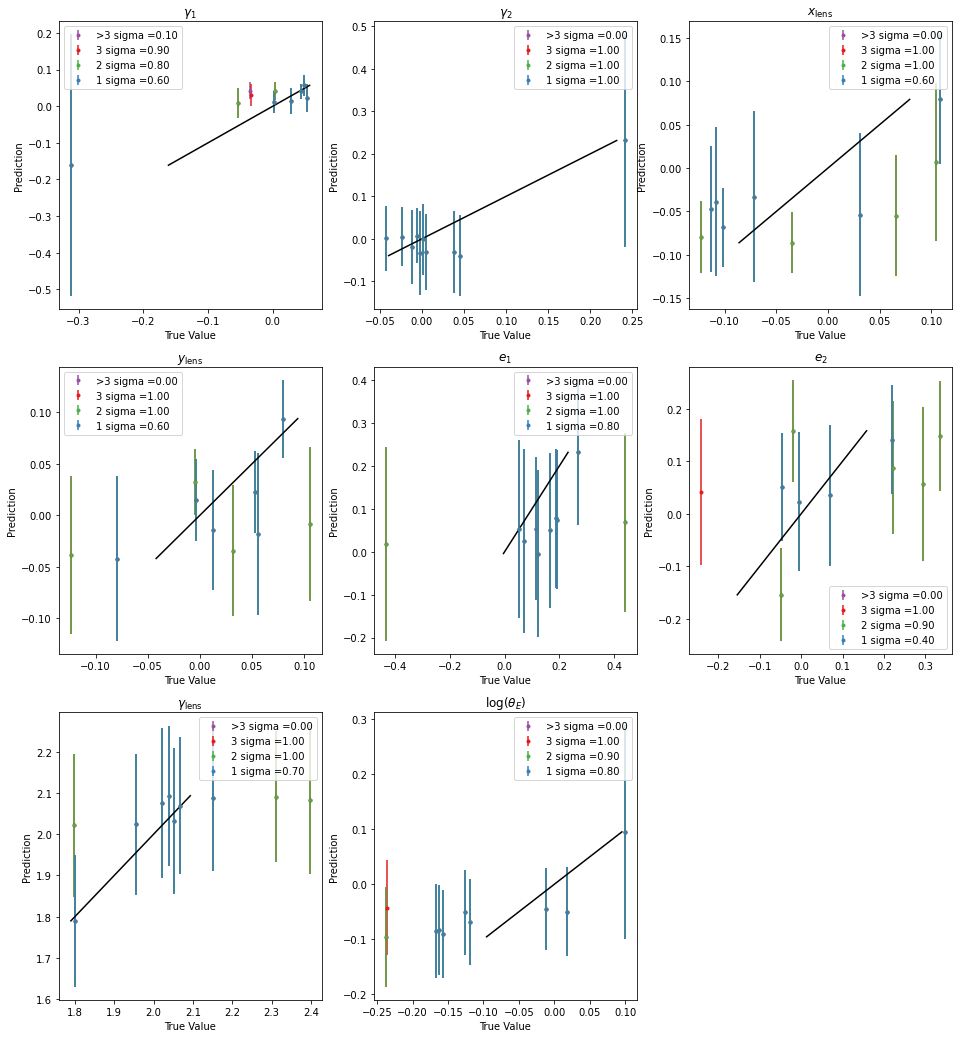

In [4]:
bnn_infer.gen_coverage_plots()

Another good check is to see the posterior of some example images.

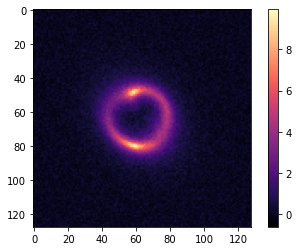

external_shear_g1 0.052765198
external_shear_g2 0.0014196595
lens_mass_center_x -0.07150146
lens_mass_center_y -0.12364617
lens_mass_e1 0.06967367
lens_mass_e2 0.06853392
lens_mass_gamma 2.0389862
lens_mass_theta_E_log -0.16236944


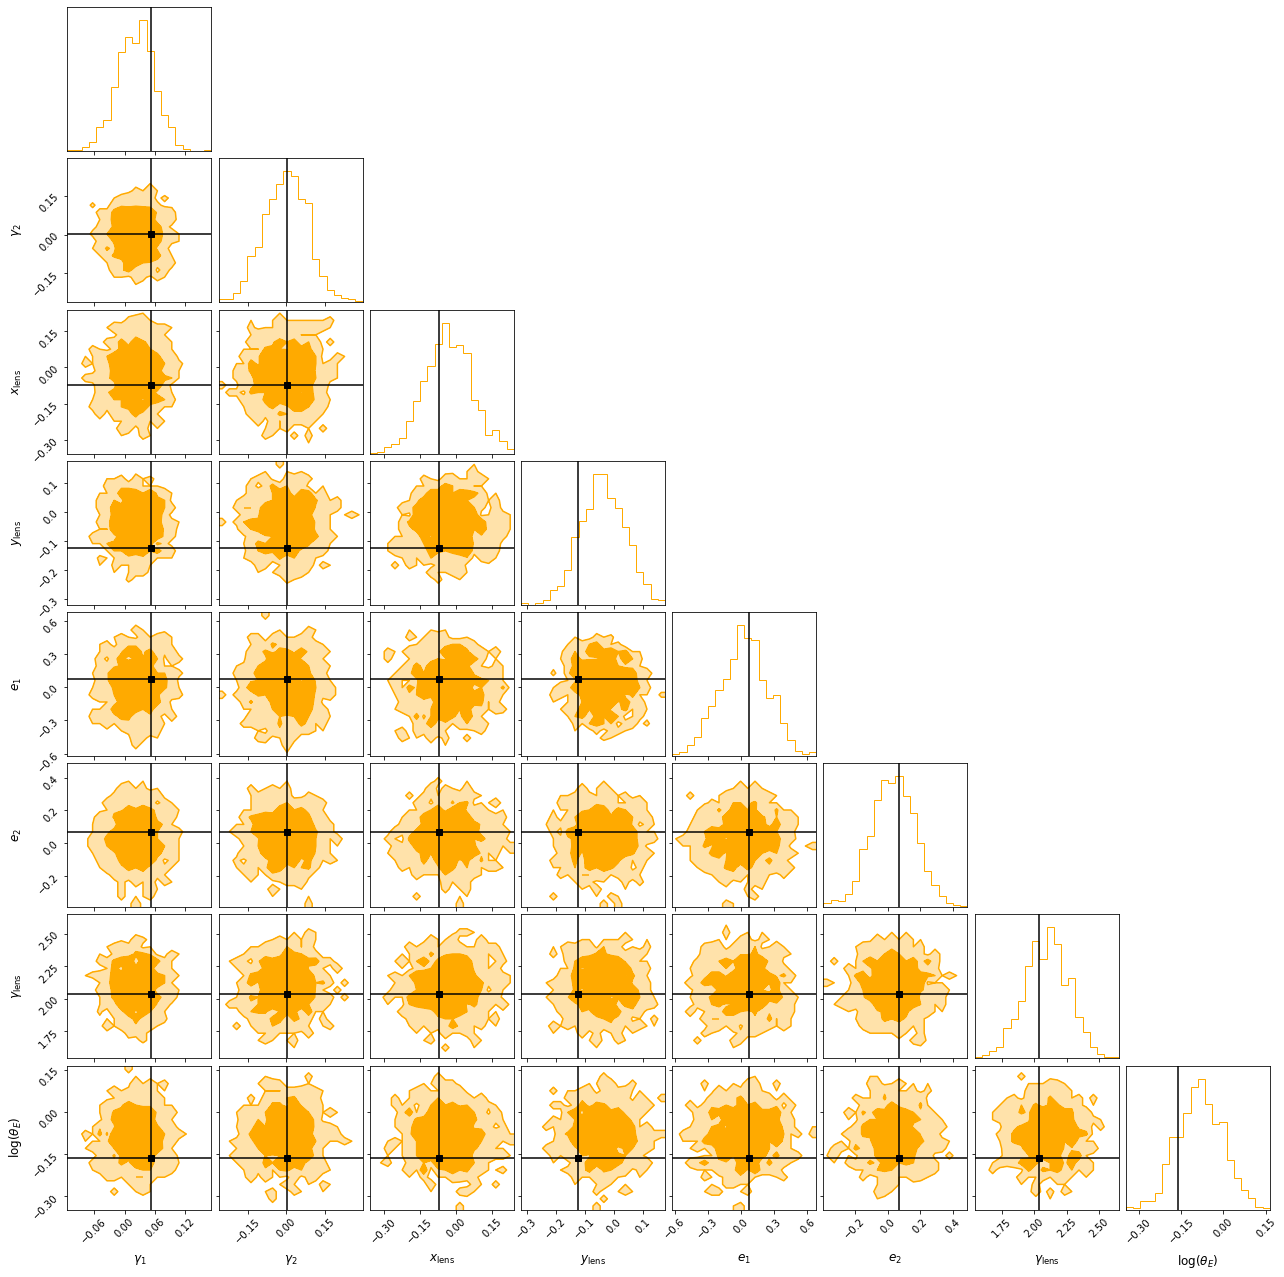

In [5]:
image_index = 5
bnn_infer.plot_posterior_contours(image_index)

It's important to understand where our uncertainty is coming from. We can inspect wether our uncertainty is dominated by aleatoric or epistemic sources. 

/home/parlange/ovejero/ovejero/bnn_inference.py:514: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+self.final_params_print_names)
/home/parlange/ovejero/ovejero/bnn_inference.py:515: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0]+self.final_params_print_names)


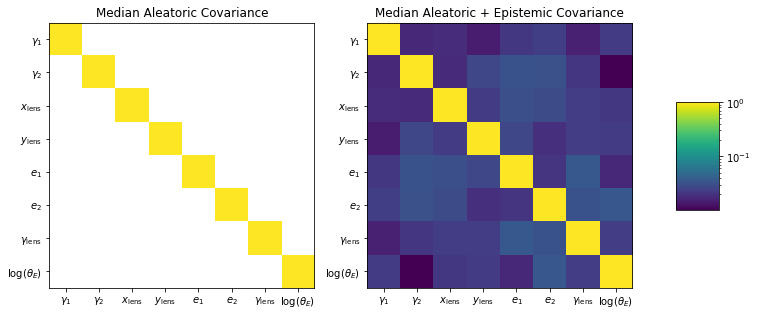

/home/parlange/ovejero/ovejero/bnn_inference.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[0].set_xticklabels([0]+self.final_params_print_names)
/home/parlange/ovejero/ovejero/bnn_inference.py:530: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[0].set_yticklabels([0]+self.final_params_print_names)


[<Figure size 864x360 with 3 Axes>, <Figure size 432x432 with 2 Axes>]

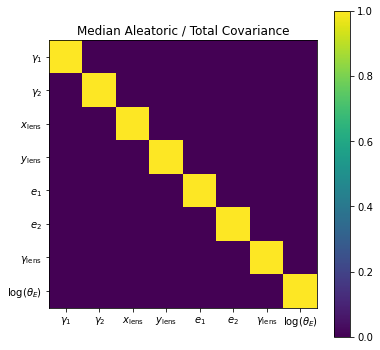

In [6]:
bnn_infer.comp_al_ep_unc()

At the end what we want our network's posterior to be well calibrated. That means that the truth should be a representative draw from the distribution we're predicting. The exact sampling that goes into the calibration plot is complicated, but the x axis repesents how much of the data the model expects to fall within a certain region of our posterior, and the y axis represents how much data actually falls within that region. Ideally this would be a straight line (y=x), but in practice our model is likely to be overconfident, underconfident, or some combination of both. The lower right hand corner of our plot represents overconfidence, and the upper right hand corner represents underconfidence.

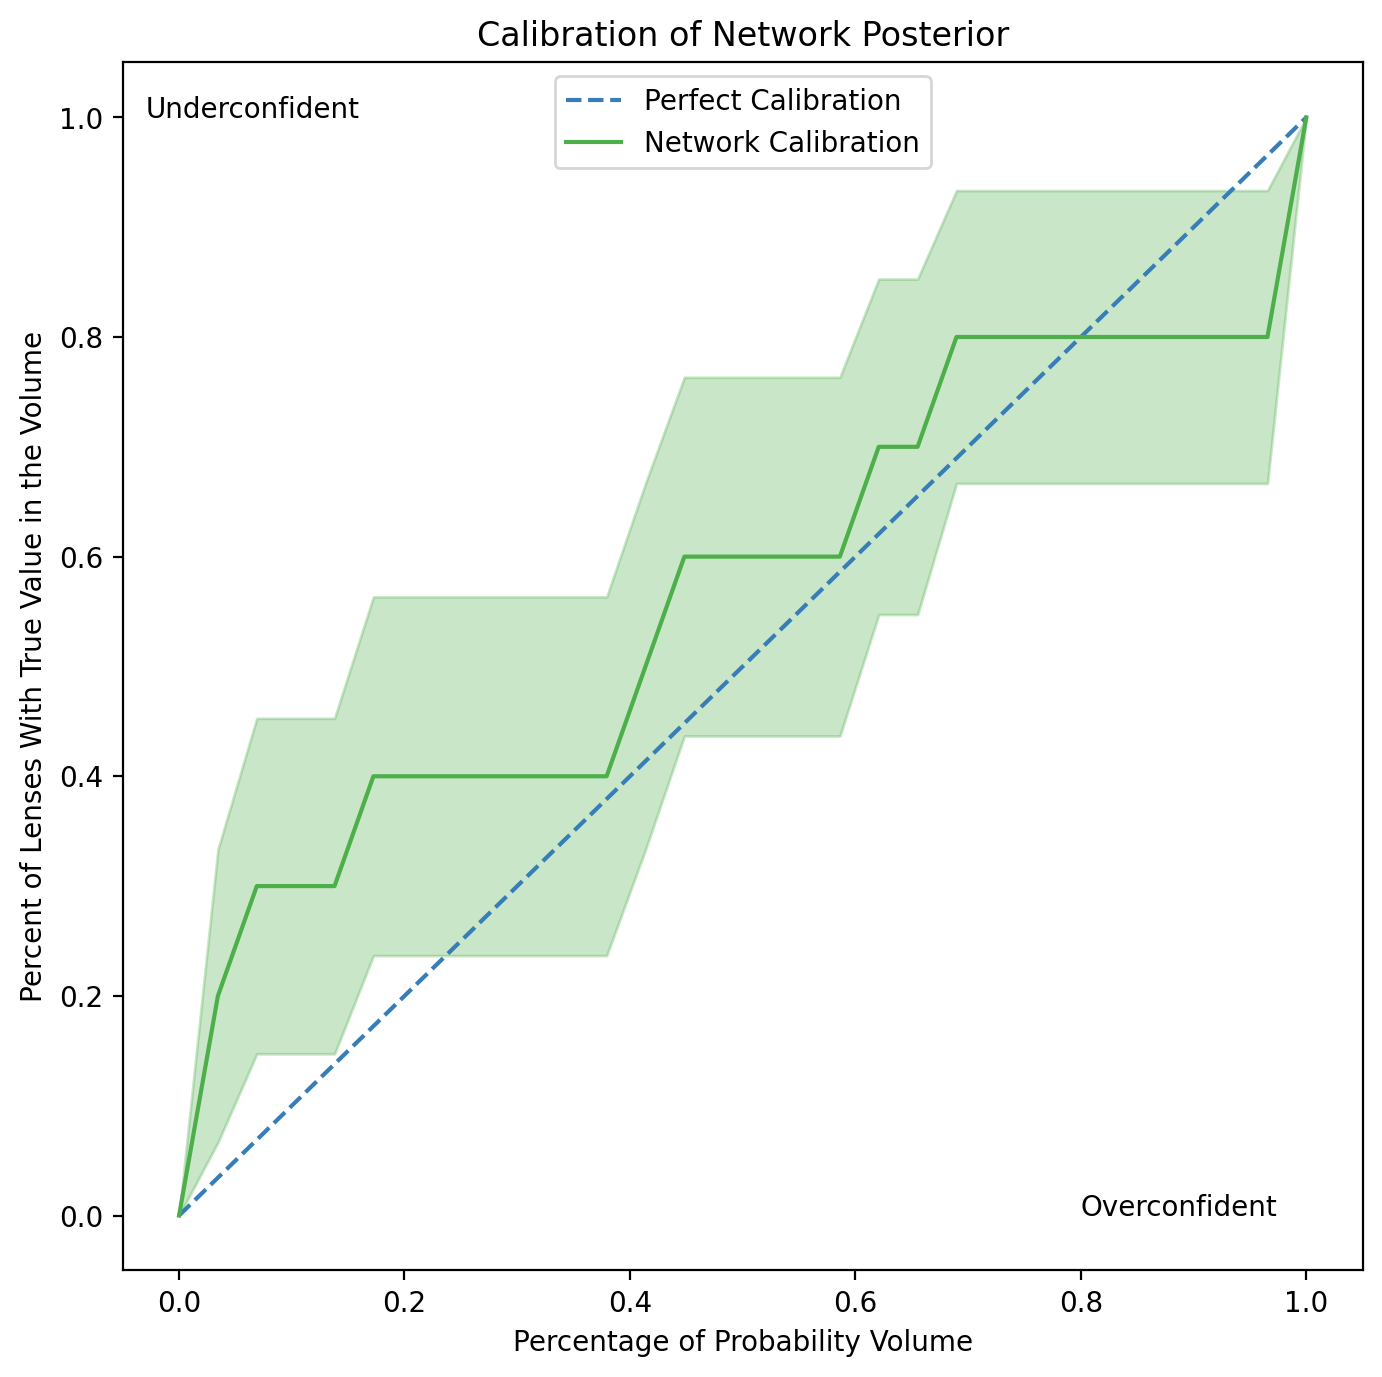

In [7]:
color_map = ["#377eb8", "#4daf4a"]
n_perc_points = 30
fig = bnn_infer.plot_calibration(color_map=color_map,n_perc_points=n_perc_points)

 ## Understanding the Calibration Plot

Throughout our paper we argue that the calibration plot is the best metric to asses the quality of the BNN posterior. Here, we include a few examples to give a better feel for the calibration plot. We focus on toy 2D models since those are easy to visualize and conceptualize. We can start with a biased 2D posterior prediction.

In [8]:
# First we'll make a class to generate our comparison
matplotlib.rcParams.update({'font.size': 13})
def plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws,
                              fit_guass_data=False):
    bnn_toy = bnn_inference.InferenceClass(cfg)
    # We generate our toy data 
    data = np.random.multivariate_normal(data_mean,data_cov,(toy_batch_size))

    # Now we generate our posterior means and covariances
    post_samples = np.random.multivariate_normal(post_mean,post_cov,(n_draws,toy_batch_size))

    # We change our bnn inference instance to have these values
    bnn_toy.samples_init = True
    bnn_toy.y_pred = np.mean(post_samples,axis=0)
    bnn_toy.predict_samps = post_samples
    bnn_toy.y_test = data
    
    # We can visualize the true data and the posterior, and compare that to the calibration plot.
    color_map=["#377eb8", "#4daf4a"]
    fig = corner.corner(post_samples.reshape(-1,2),bins=20,labels=['x','y'],show_titles=False, plot_datapoints=False,
                  label_kwargs=dict(fontsize=15),levels=[0.68,0.95],dpi=200, 
                  color=color_map[1],fill_contours=True,range=[[-6,6],[-6,6]])
    fig.axes[2].plot(data[:,0],data[:,1],'.',c=color_map[0],alpha=0.1)
    post_line = mlines.Line2D([], [], color=color_map[0], label='True Posterior')
    data_line = mlines.Line2D([], [], color=color_map[1], label='Inferred Posterior')
    plt.legend(handles=[post_line,data_line], bbox_to_anchor=(0.05, 1.0, 1., .0), loc=4,fontsize=12)
    plt.show()
    
    cal_fig = bnn_toy.plot_calibration(n_perc_points=30,title='',
                                       legend=['Perfect Calibration','Inferred Posterior Calibration'])
    
    return (fig,cal_fig)

Is model built: True
Loaded weights /home/parlange/ovejero/test/test_data/test_model.h5
TFRecord found at /home/parlange/ovejero/test/test_data/tf_record_test_val


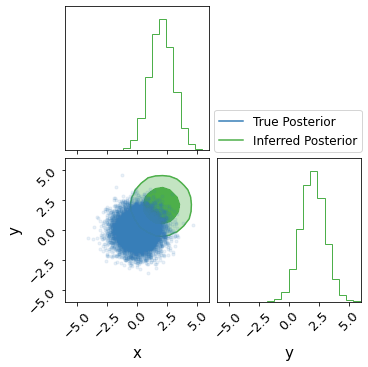

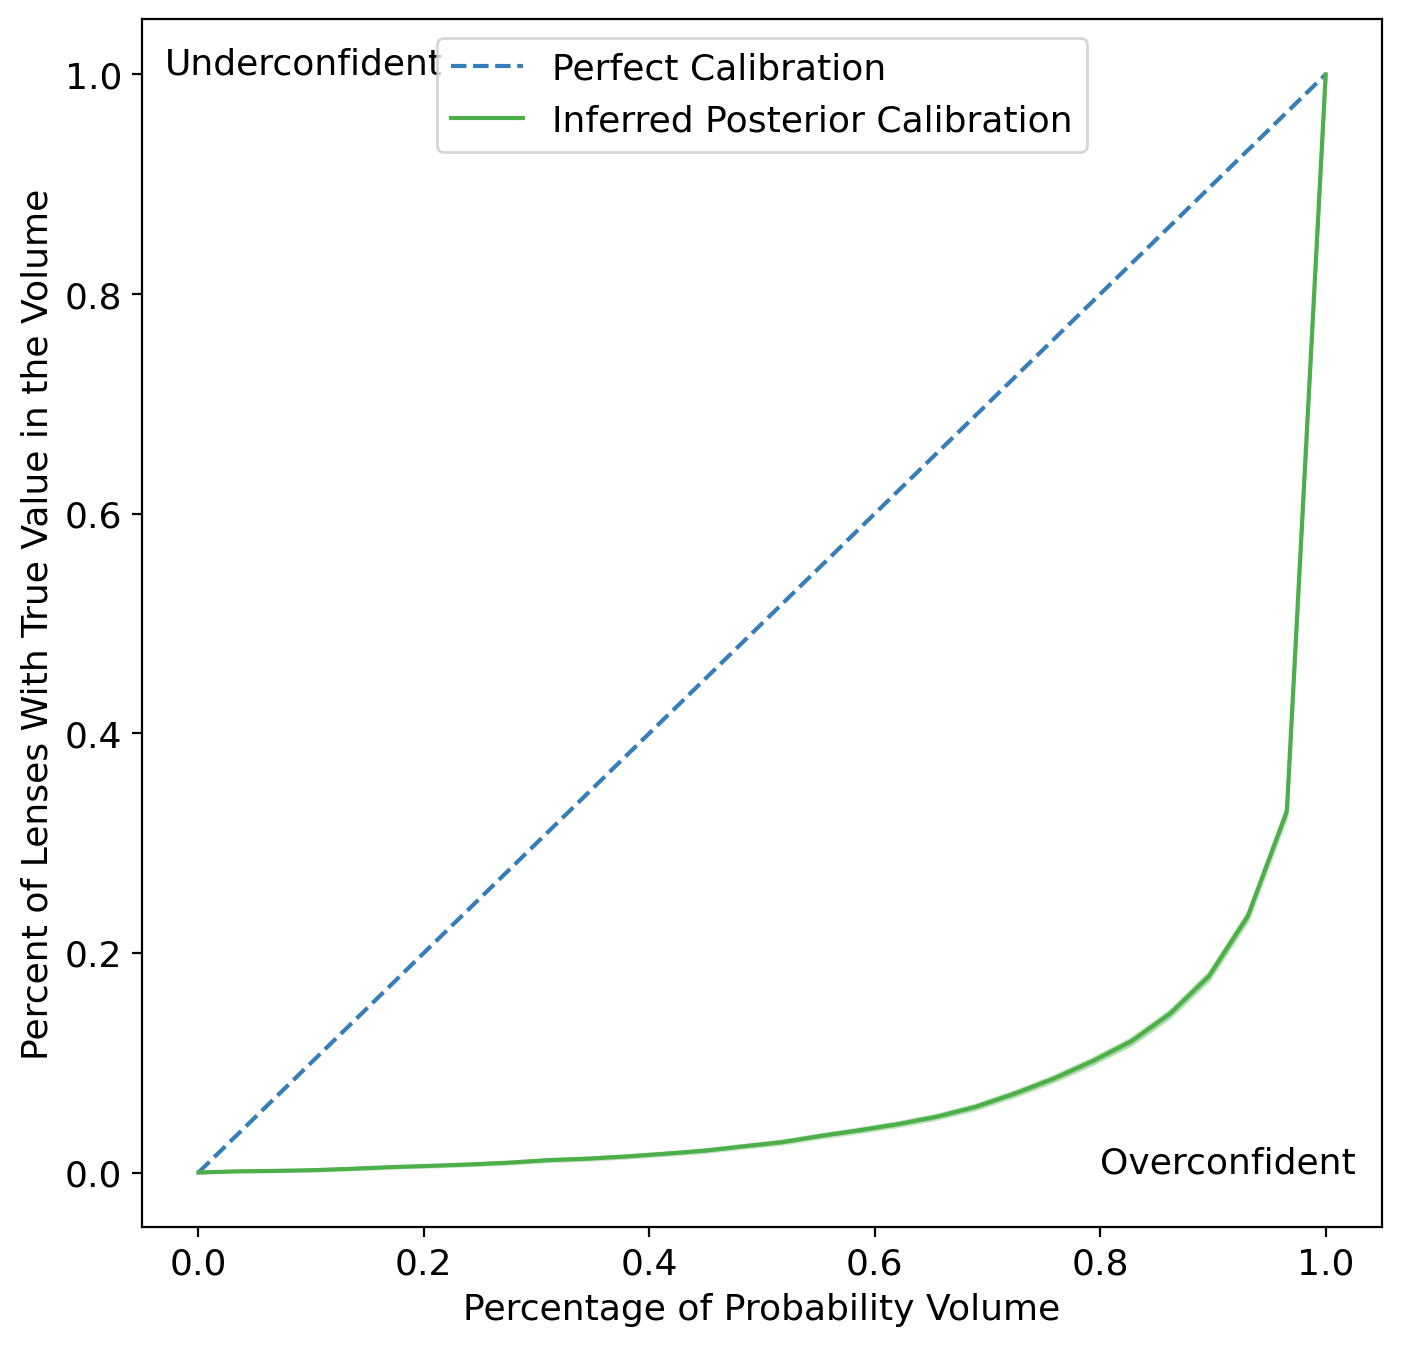

In [9]:
# We start with our offset posterior
data_mean = np.zeros(2)
data_cov = np.eye(2)
toy_batch_size = 10000
n_draws = 1000
post_mean = np.ones(2)*2
post_cov=np.eye(2)
post_fig, cal_fig = plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws)
post_fig.savefig('/home/parlange/ovejero/paper/offset_corn.pdf')
cal_fig.savefig('/home/parlange/ovejero/paper/offset_cal.pdf')

The posterior we're predicting is offset from the truth, so our model is consistently overconfident. We can repeat the exercise with a posterior that is correctly centered but has a much tighter contour. We still expect our model to be overconfident.

Is model built: True
Loaded weights /home/parlange/ovejero/test/test_data/test_model.h5
TFRecord found at /home/parlange/ovejero/test/test_data/tf_record_test_val


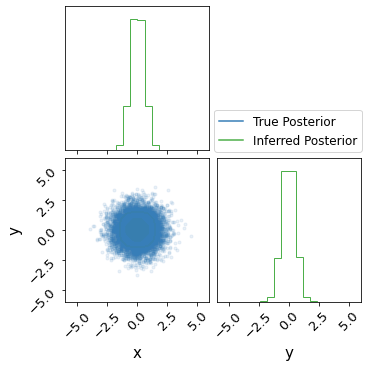

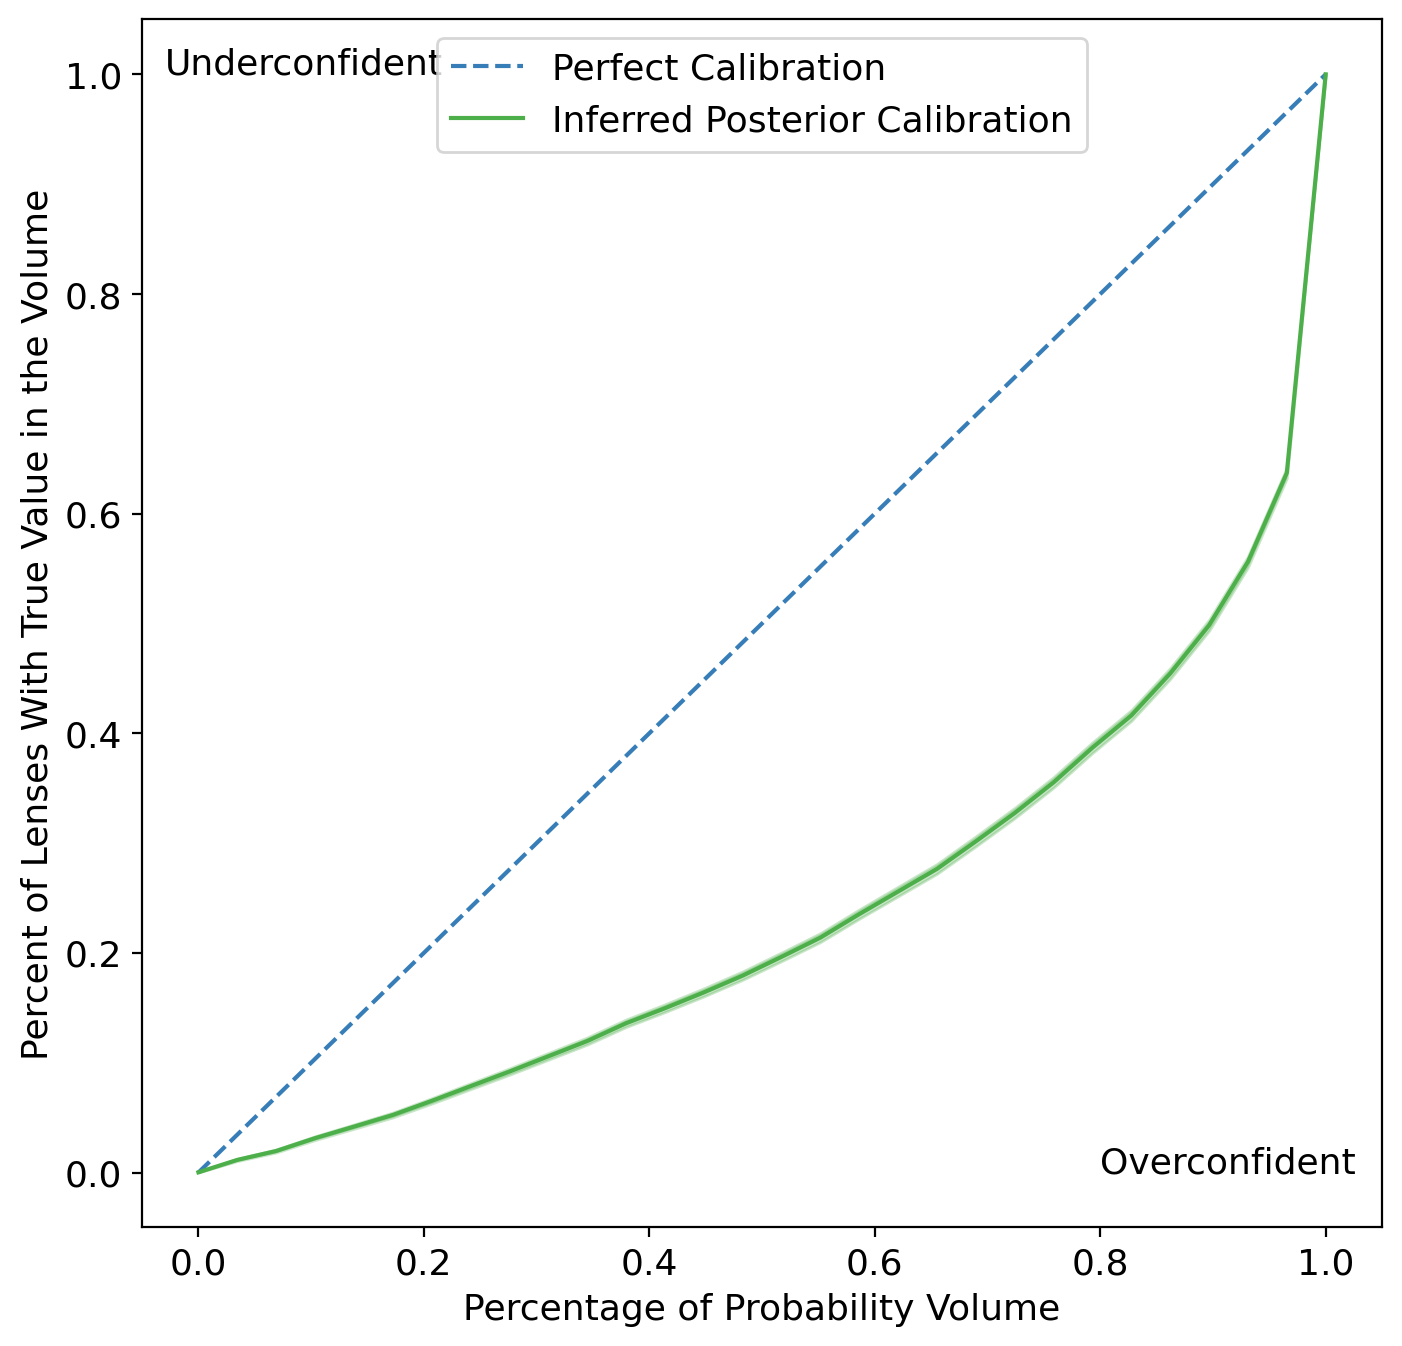

In [10]:
data_mean = np.zeros(2)
data_cov = np.eye(2)
toy_batch_size = 10000
n_draws = 1000
post_mean = np.zeros(2)
post_cov=np.eye(2)*0.3
_ = plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws = 1000)

Once again, our model is overconfident. We can similary see what happens when our model is underconfident by expanding our contours.

Is model built: True
Loaded weights /home/parlange/ovejero/test/test_data/test_model.h5
TFRecord found at /home/parlange/ovejero/test/test_data/tf_record_test_val


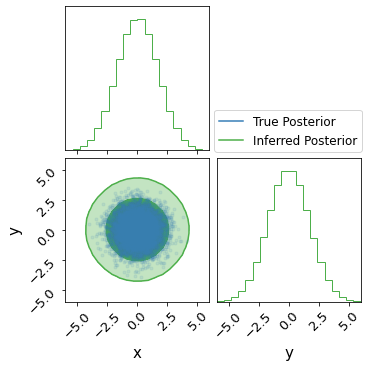

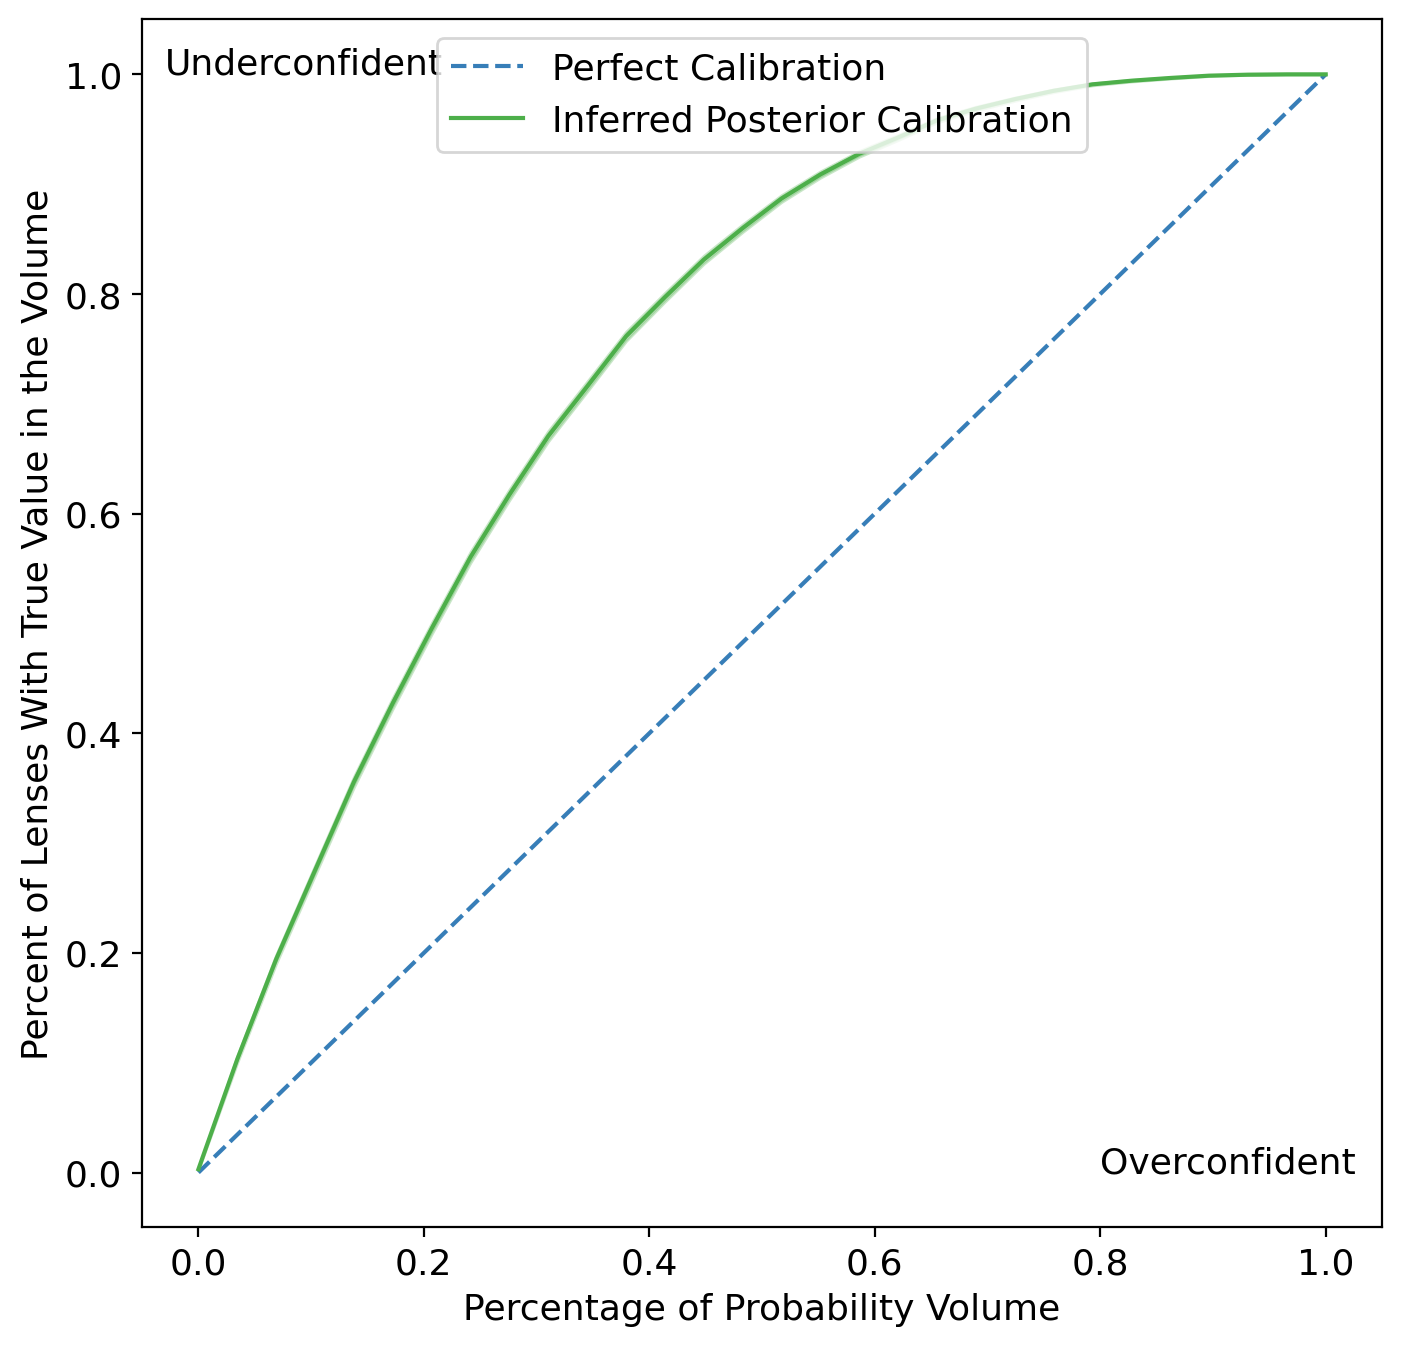

In [11]:
data_mean = np.zeros(2)
data_cov = np.eye(2)
toy_batch_size = 10000
n_draws = 1000
post_mean = np.zeros(2)
post_cov=np.eye(2)*3
post_fig, cal_fig = plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws)
post_fig.savefig('/home/parlange/ovejero/paper/underconf_corn.pdf')
cal_fig.savefig('/home/parlange/ovejero/paper/underconf_cal.pdf')

The model posterior here is underconfident - almost 90% of the data falls within the 1 sigma countour. We can look at a more realistic example - a Gaussian posterior with no covariance trying to fit data with covariance.

Is model built: True
Loaded weights /home/parlange/ovejero/test/test_data/test_model.h5
TFRecord found at /home/parlange/ovejero/test/test_data/tf_record_test_val


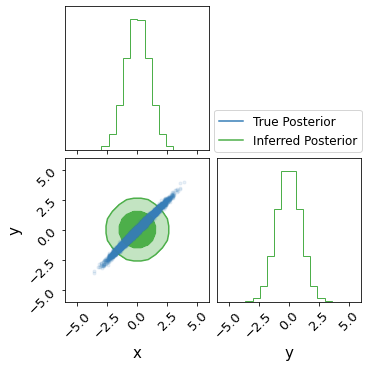

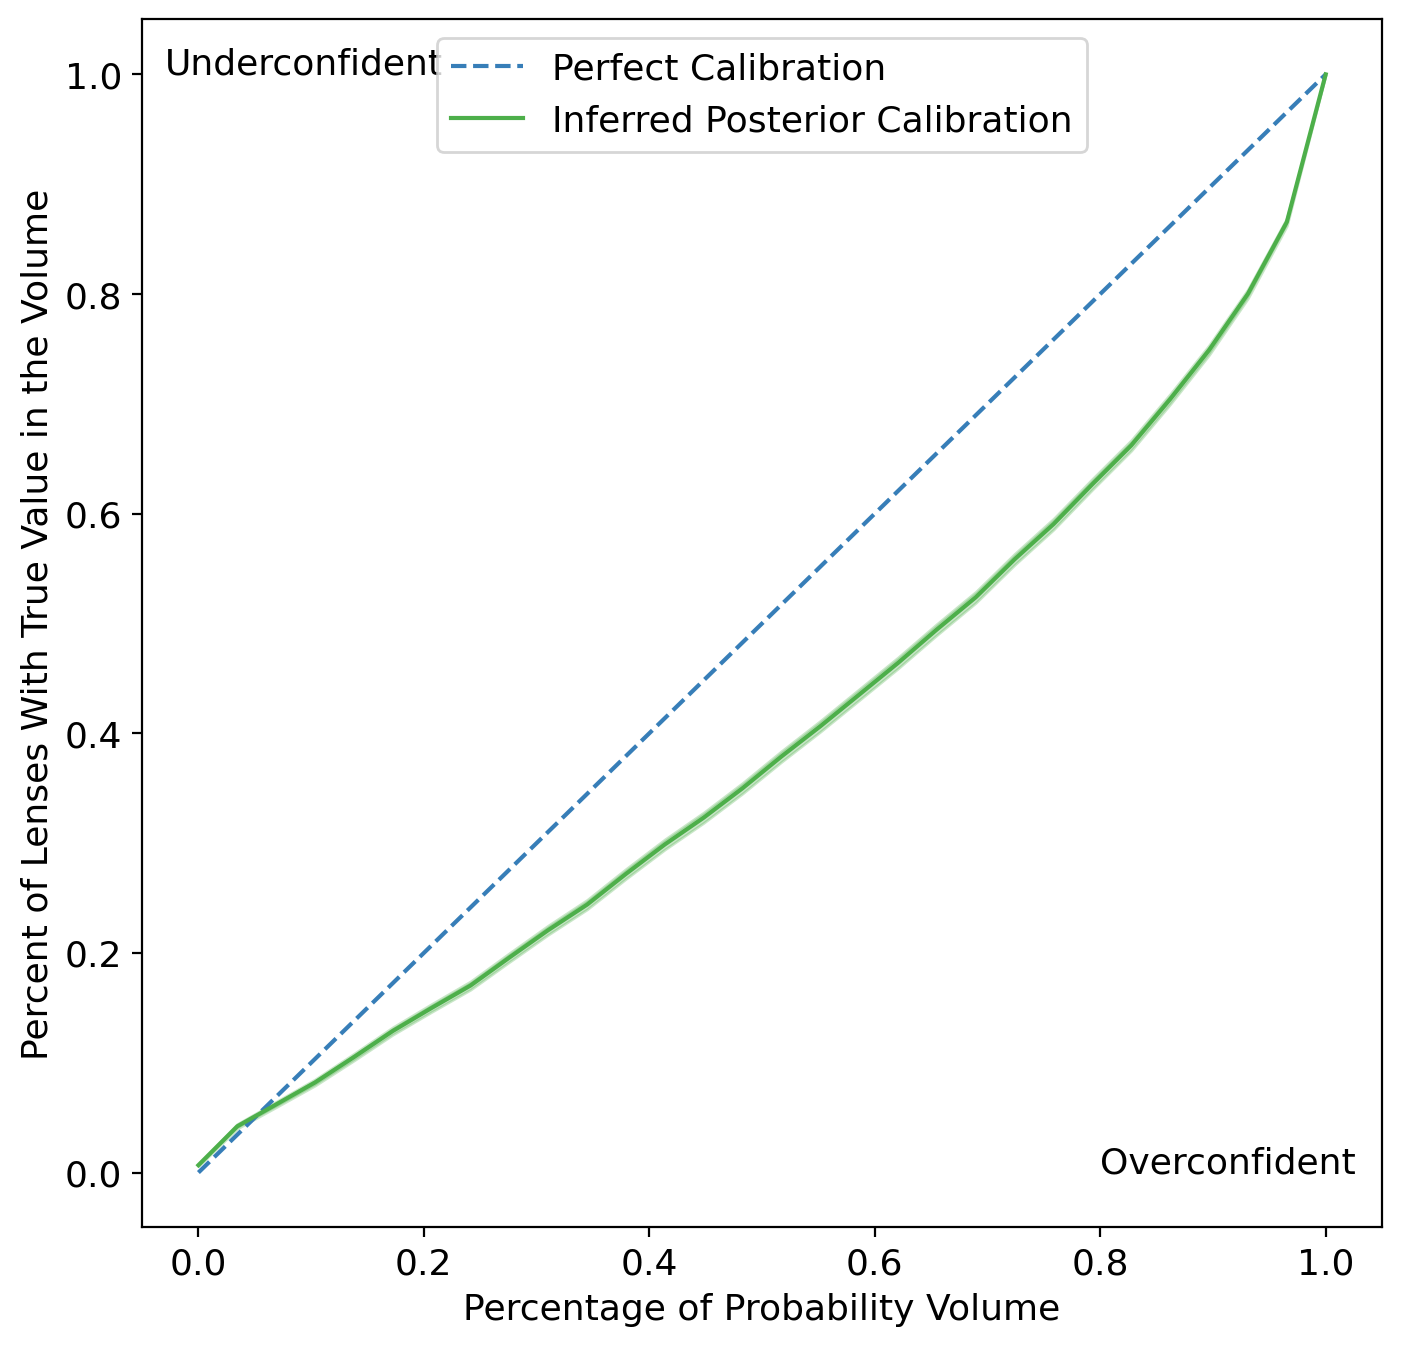

In [12]:
# We start with our offset posterior
data_mean = np.zeros(2)
data_cov = np.array([[1,0.99],[0.99,1]])
toy_batch_size = 10000
n_draws = 1000
post_mean = np.zeros(2)
post_cov=np.diag(np.std(np.random.multivariate_normal(data_mean,data_cov,(toy_batch_size)),axis=0))
_ = plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws)

This comes off mostly as overconfident by our network - it's not capturing the extreme covariance in the data, causing the networks contours to assign too little probabilistic weight to the tails.

Another issue our network may have is that the posterior we pick is not sufficiently multimodal to capture the true distribution of the data (or the multimodality is poorly tuned). We can see what this looks like by fitting a full covariance matrix posterior to multimodal data.

In [13]:
# First we'll make a class to generate our comparison
def plot_toy_model_calibration_gm(data_means,data_covs,post_mean,post_cov,toy_batch_size,ps,n_draws,
                              fit_guass_data=False):
    bnn_toy = bnn_inference.InferenceClass(cfg)
    # We generate our toy data 
    data = []
    for dmi in range(len(data_means)):
        data.append(np.random.multivariate_normal(data_means[dmi],data_covs[dmi],(int(toy_batch_size*ps[dmi]))))
    data = np.concatenate(data,axis=0)
    
    if fit_guass_data == True:
        post_mean = np.mean(data,axis=0)
        post_cov=np.diag(np.std(data,axis=0))

    # Now we generate our posterior means and covariances
    post_samples = np.random.multivariate_normal(post_mean,post_cov,(n_draws,toy_batch_size))

    # We change our bnn inference instance to have these values
    bnn_toy.samples_init = True
    bnn_toy.y_pred = np.mean(post_samples,axis=0)
    bnn_toy.predict_samps = post_samples
    bnn_toy.y_test = data
    
    # We can visualize the true data and the posterior, and compare that to the calibration plot.
    color_map=["#377eb8", "#4daf4a"]
    fig = corner.corner(post_samples.reshape((-1,2)),bins=20,labels=['x','y'],show_titles=False, 
                        plot_datapoints=False,label_kwargs=dict(fontsize=15),levels=[0.68,0.95],dpi=1600, 
                        color=color_map[1],fill_contours=True,range=[[-6,6],[-6,6]])
    fig.axes[2].plot(data[:,0],data[:,1],'.',c=color_map[0],alpha=0.1)
    post_line = mlines.Line2D([], [], color=color_map[0], label='True Posterior')
    data_line = mlines.Line2D([], [], color=color_map[1], label='Inferred Posterior')
    plt.legend(handles=[data_line,post_line], bbox_to_anchor=(0.05, 1.0, 1., .0), loc=4,fontsize=12.0)
    plt.show()
    cal_fig = bnn_toy.plot_calibration(n_perc_points=30,title='',
                                       legend=['Perfect Calibration','Inferred Posterior Calibration'])
    return (fig,cal_fig)

Is model built: True
Loaded weights /home/parlange/ovejero/test/test_data/test_model.h5
TFRecord found at /home/parlange/ovejero/test/test_data/tf_record_test_val


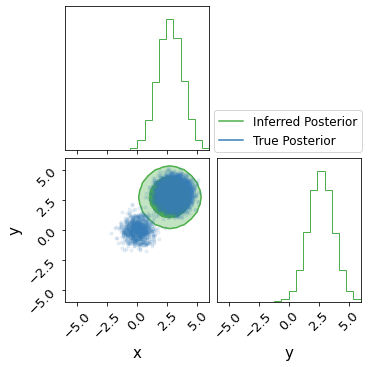

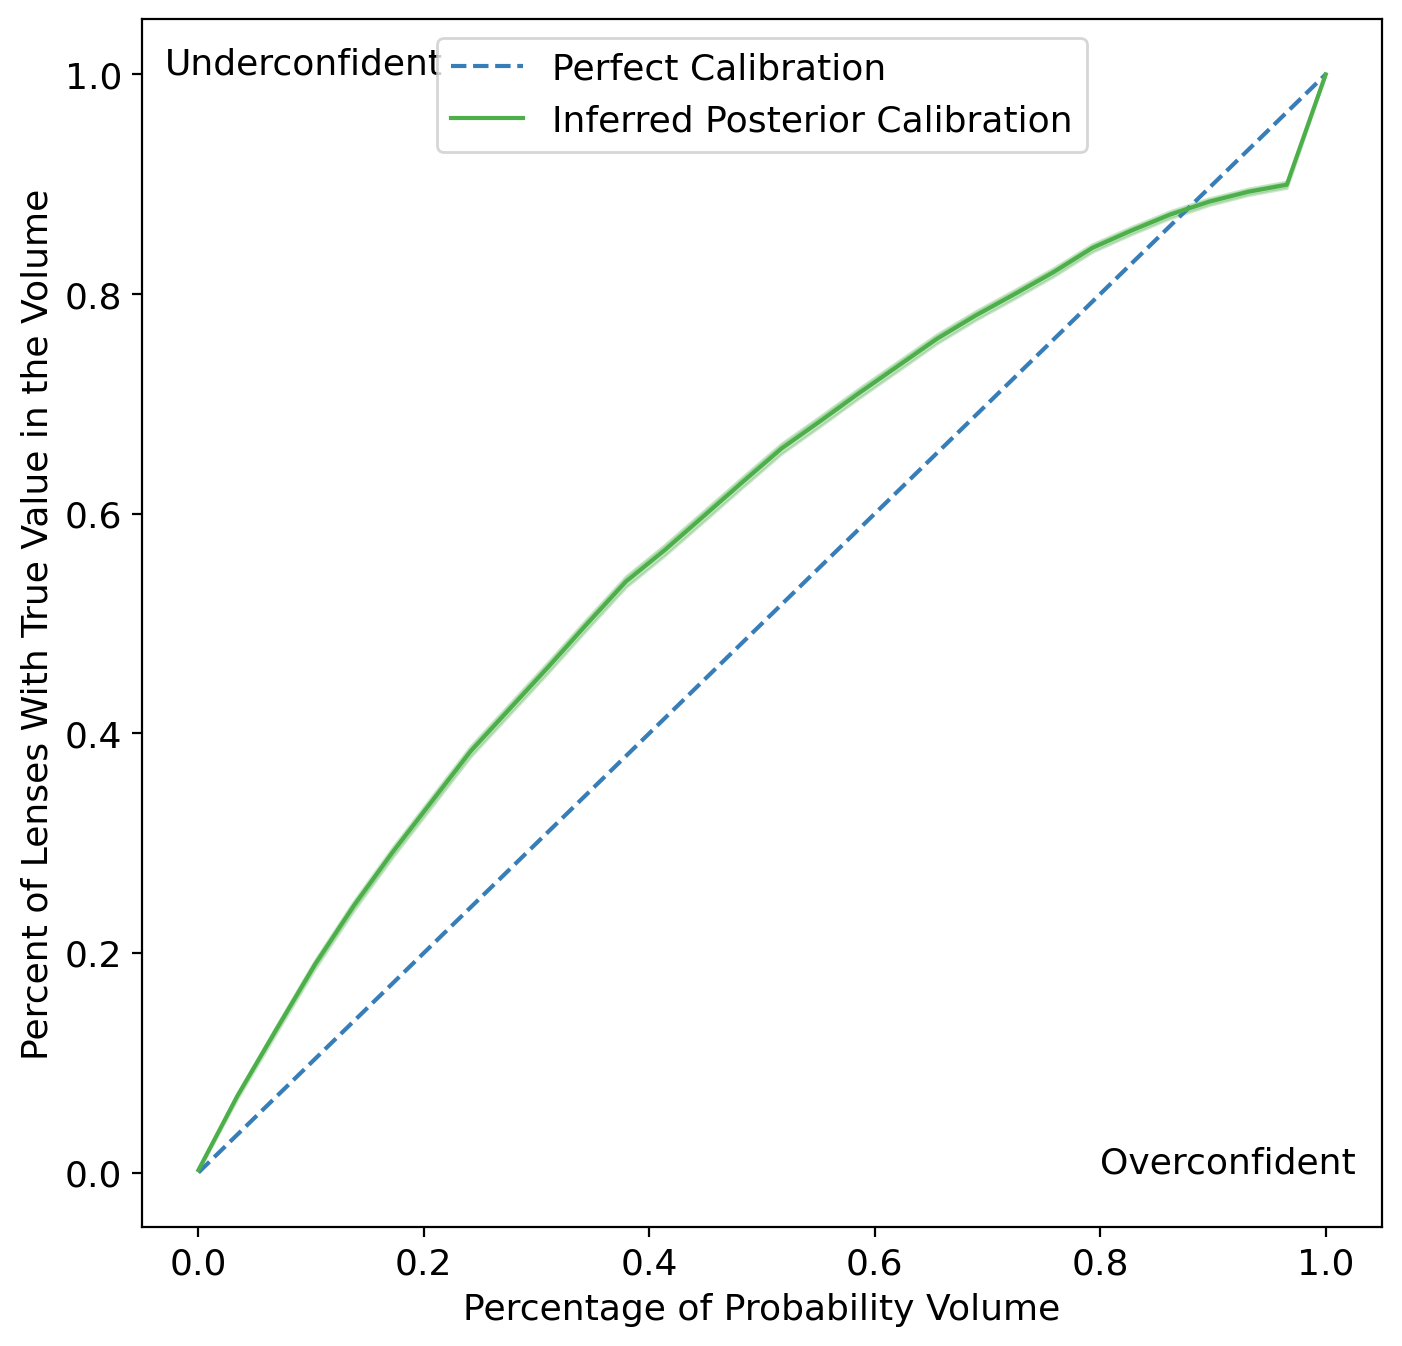

In [14]:
# Estimate a single Gaussian from the multimodal data.
data_means = [np.ones(2)*3,np.zeros(2)]
data_covs = [np.array([[0.4,0],[0,0.4]]),np.array([[0.4,0],[0,0.4]])]
ps = [0.9,0.1]
toy_batch_size = 10000
n_draws = 1000

data = []
for dmi in range(len(data_means)):
    data.append(np.random.multivariate_normal(data_means[dmi],data_covs[dmi],(toy_batch_size//len(
    data_mean))))
data = np.concatenate(data,axis=0)

post_mean = np.mean(data,axis=0)
post_cov=np.diag(np.std(data,axis=0))
post_fig, cal_fig = plot_toy_model_calibration_gm(data_means,data_covs,post_mean,post_cov,toy_batch_size,
                                                  ps,n_draws,fit_guass_data=True)
post_fig.savefig('/home/parlange/ovejero/paper/biv_corn.pdf')
cal_fig.savefig('/home/parlange/ovejero/paper/biv_cal.pdf')

Interestingly, the multimodal data leads to both under and over confidence by our network. In the interior region, corresponding to the principle mode, the toy prediction is has slightly too large covariances. In the tails, where our second mode becomes relevant, our single Gaussian prediction is suddenly very underconfident (since it assigns almost no weight to the second mode).